In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
#import time
import matplotlib.pyplot as plt

import warnings

import utils

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [4]:
df_portofolio, df_quotes, _, _ = utils.load_data()
df_quotes = df_quotes.bfill()
code2name_dict = df_portofolio['Nome'].to_dict()

In [5]:
def get_quote_date(days_ago: int):
    return df_quotes.index[df_quotes.index <= (df_quotes.index[0]-pd.Timedelta(days=days_ago))].max()

def oscilator(ts, period=21, smooth_k=3):
    # Calculate the highest high and lowest low over the specified period
    data = ts.sort_index()[-period-smooth_k:]
    highest_high = data.rolling(window=period).max()
    lowest_low = data.rolling(window=period).min()
    
    # Calculate %K
    percent_k = ((data - lowest_low) / (highest_high - lowest_low)) * 100
    
    # Smooth %K using a moving average
    smooth_k_line = percent_k.rolling(window=smooth_k).mean()
    return smooth_k_line.iloc[-2:]

div_f = 365 / 53
def get_kpis(days_ago: int = 365 //div_f, base_return: float=0.03):
    days_ago_std = 365 // 2
    start_date = get_quote_date(days_ago=days_ago)
    start_date_std = get_quote_date(days_ago=days_ago_std)
    df_features = pd.DataFrame(index=df_quotes.columns)
    #df_features['Name'] = df_features.apply(lambda x: code2name_dict.get(x.name,x.name),axis=1)
    df_features['Growth'] = df_quotes.apply(lambda x: (x.iloc[0]/x.loc[start_date])**(div_f)-1)
    df_features['STD'] = df_quotes.loc[:start_date_std].apply(lambda x: x/x.shift(-1), axis=0).std(axis=0)
    df_features['Racio'] = (df_features['Growth']-base_return)/df_features['STD']
    ds = df_quotes.loc[:start_date].apply(lambda x: x/x.shift(-1)-1, axis=0).clip(upper=0)**2
    df_features['D_Volat'] = np.sqrt(ds.mean())
    df_features['Racio2'] = (df_features['Growth']-base_return)*2/(df_features['STD'] + df_features['D_Volat']*2)
    ts_min, ts_max, ts_last = df_quotes.min(), df_quotes.max(), df_quotes.iloc[0,:]
    df_features['PricePosition'] = (ts_last-ts_min)/(ts_max-ts_min)
    osc_df = df_quotes.apply(lambda x: oscilator(x), axis=0)
    df_features['Oversold Exit'] = osc_df.apply(lambda x: (x.iloc[1]>20) & (x.iloc[0]<20))
    df_features['Overbought Entry'] = osc_df.apply(lambda x: (x.iloc[1]>80) & (x.iloc[0]<80))
    return df_features[df_features['STD']>0].sort_values(by='Racio',ascending=False)

df_features = get_kpis()
last_quotes = df_quotes.iloc[0]
df_features['Amount EUR'] = last_quotes * df_portofolio['Quantidade']

In [6]:
def change_trend(ts: pd.Series, long_window: int=30, short_window:int=10, kpi_window:int=130, lag:int=1):
    ts = ts.sort_index()
    short_ma = ts.ewm(span=short_window, adjust=False).mean()
    short_ma.name = 'short_ma'
    long_ma = ts.ewm(span=long_window, adjust=False).mean()
    long_ma.name ='long_ma'
    if short_ma.iloc[-1-lag] < long_ma.iloc[-1-lag] and short_ma.iloc[-1] > long_ma.iloc[-1]:
        # Short-term MA crosses above long-term MA: Upward trend
        status = "Up"
    elif short_ma.iloc[-1-lag] > long_ma.iloc[-1-lag] and short_ma.iloc[-1] < long_ma.iloc[-1]:
        # Short-term MA crosses below long-term MA: Downward trend
        status = "Down"
    else:
        # No recent trend change
       status = "NaN"
    sma_growth = short_ma.iloc[-1] / short_ma.iloc[-1-short_window]
    ts_min, ts_max = ts.iloc[-kpi_window:].min(), ts.iloc[-kpi_window:].max()
    price_position = (ts.iloc[-1]-ts_min)/(ts_max-ts_min)
    return status, short_ma, long_ma, sma_growth, price_position

def volatility(returns: pd.Series):
    return np.sqrt((returns**2).mean())

def print_fund_change(symb: str):
    _, sma, lma,_,_ = change_trend(df_quotes[symb])
    df_tmp = pd.concat([df_quotes[symb],sma,lma],axis=1)
    title = code2name_dict.get(symb,'')
    df_tmp.iloc[:130].plot(title=title,figsize=(12,4))
    plt.show()
    #returns = df_quotes[symb].pct_change().dropna()
    #avg_returns = returns.mean()
    #print(f"Downside Volatiliy:{volatility(returns.clip(upper=avg_returns))}. Upside Volatiliy:{volatility(returns.clip(lower=avg_returns))}.")

def plot_stochastic_oscillator(symb: str, period=14, smooth_k=3, smooth_d=3):
    """
    Calculate and plot the Stochastic Oscillator for an asset.
    
    Parameters:
        symb (str): The symbol to use.
        period (int): The lookback period for calculating the Stochastic Oscillator. Default is 14.
        smooth_k (int): The smoothing period for %K. Default is 3.
        smooth_d (int): The smoothing period for %D (signal line). Default is 3.
    """
    # Ensure the symbol is valid
    if symb not in df_quotes.columns:
        raise ValueError(f"The symbol '{symb}' does not exist in the data.")
    
    data = df_quotes[symb].sort_index()
    
    # Calculate the highest high and lowest low over the specified period
    highest_high = data.rolling(window=period).max()
    lowest_low = data.rolling(window=period).min()
    
    # Calculate %K
    percent_k = ((data - lowest_low) / (highest_high - lowest_low)) * 100
    
    # Smooth %K using a moving average
    smooth_k_line = percent_k.rolling(window=smooth_k).mean()
    
    # Calculate %D (signal line) as a moving average of %K
    percent_d = smooth_k_line.rolling(window=smooth_d).mean()
    
    # Plot the Stochastic Oscillator
    plt.figure(figsize=(12, 2))
    plt.plot(smooth_k_line.iloc[-130:], label=f"%K (Fast Line, {smooth_k}-period)", color='lightblue')
    #plt.plot(percent_d, label=f"%D (Signal Line, {smooth_d}-period)", color='orange')
    plt.axhline(80, color='red', linestyle='--', label='Overbought (80)')
    plt.axhline(20, color='green', linestyle='--', label='Oversold (20)')
    #plt.title(f"{code2name_dict.get(symb,'')} Stochastic Oscillator")
    #plt.xlabel("Date")
    #plt.ylabel("Oscillator Value")
    #plt.legend()
    #plt.grid()
    plt.show()

def buy_opps_change_trend(lag:int=1,growth_treshold:int=1.0005, relative_price_treshold:int=1.5, graph=True):
    print("####################  BUY OPPS  #####################")
    df_change_opp = pd.DataFrame(
        [(symb,g,pp) for x,_,_,g,pp,symb in [change_trend(ts=df_quotes[symb],lag=lag)+(symb,) for symb in df_quotes.columns] if x == 'Up'],
        columns=['symb','growth','relative_price']
        ).sort_values(by='relative_price')
    df_change_opp = df_change_opp[(df_change_opp['growth']>growth_treshold) & (df_change_opp['relative_price']<relative_price_treshold)]
    if graph:
        for symb in df_change_opp['symb']:
            print_fund_change(symb)
    return df_change_opp['symb']

def sell_opps(lag:int=1):
    print("####################  SELL OPPS  #####################")
    df_change_opp = pd.DataFrame(
        [(symb,g,pp) for x,_,_,g,pp,symb in [change_trend(df_quotes[symb], lag=lag)+(symb,) for symb in df_portofolio.index] if x == 'Down'],
        columns=['symb','growth','relative_price']
        ).sort_values(by='relative_price')
    for symb in df_change_opp['symb']:
        print_fund_change(symb)
    return df_change_opp['symb']

def portofolio_trend(fund_list=df_portofolio.index):
    print("####################  PORTOFOLIO TRENDS  #####################")
    for symb in fund_list:
        print_fund_change(symb)


### Evaluate Portofolio

In [7]:
df_plot = df_features.loc[df_portofolio.index].sort_values(by='Racio2',ascending=False)
df_plot['Name'] = df_plot.apply(lambda x: code2name_dict.get(x.name,''),axis=1)
df_plot.sort_values(by=['Racio2'],ascending=False).to_csv('portfolio_tmp_2.csv')
df_plot

Growth       STD       Racio   D_Volat      Racio2  \
Code                                                                 
LU0524465977  1.859475  0.008838  206.999565  0.006293  170.785579   
LU0173778175  0.475421  0.003181  140.019203  0.001757  133.043837   
SC0U.DE       2.016340  0.011755  168.984787  0.009694  127.566571   
YINN          7.020434  0.068925  101.421018  0.029829  108.729706   
LU0140363267  0.407204  0.006171   61.122916  0.004301   51.063163   
SGLD.AS       0.329659  0.009080   33.002380  0.005178   30.834505   
SIVR          0.221617  0.014840   12.912319  0.006824   13.452080   
MEUD.PA       0.122819  0.006867   13.517131  0.005680   10.184643   
LU1965927921  0.030428  0.000105    4.090800  0.000000    8.181599   
IE00B3XBYN16  0.129062  0.009416   10.521164  0.007796    7.922367   
JEDI.DE      -0.389103  0.024172  -17.338237  0.019053  -13.458877   
QTUM         -0.443993  0.020487  -23.136690  0.013982  -19.565672   
STK.PA       -0.460032  0.015000  -32.669079  0.013904  -22.894023   

              PricePosition  Oversold Exit  Overbought Entry     Amount EUR  \
Code                                                                          
LU0524465977       0.995044          False             False   27077.316548   
LU0173778175       0.968326          False             False   25284.000720   
SC0U.DE            0.969676          False             False   20736.799316   
YINN               0.672582          False             False   14038.011065   
LU0140363267       0.967213          False             False   25168.920570   
SGLD.AS            0.997131          False             False   23049.451141   
SIVR               0.917836          False             False   29813.843164   
MEUD.PA            0.820456          False             False   23093.099670   
LU1965927921       1.000000          False             False  142958.620000   
IE00B3XBYN16       0.973595          False             False   14562.505297   
JEDI.DE            0.744132          False             False   20220.000458   
QTUM               0.756329          False             False   36259.705254   
STK.PA             0.607926          False             False   20202.118973   

                                              Name  
Code                                                
LU0524465977               Alken European Opport A  
LU0173778175        Nordea Swedish Short Term Bond  
SC0U.DE             Invesco STOXX Europe 600 Banks  
YINN             Direxion Daily FTSE China Bull 3X  
LU0140363267         Franklin Mutual European Fund  
SGLD.AS                  Invesco Physical Gold ETC  
SIVR                         abrdn Physical Silver  
MEUD.PA                    Amundi Stoxx Europe 600  
LU1965927921          DWS Invest ESG Floating Rate  
IE00B3XBYN16  Nomura Ireland Japan Strategic Value  
JEDI.DE                    VanEck Space Innovators  
QTUM                              Defiance Quantum  
STK.PA                 SPDR MSCI Europe Technology

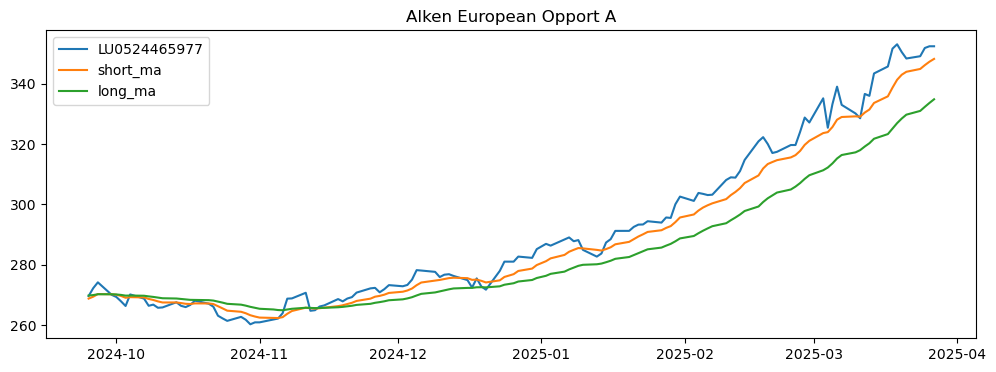

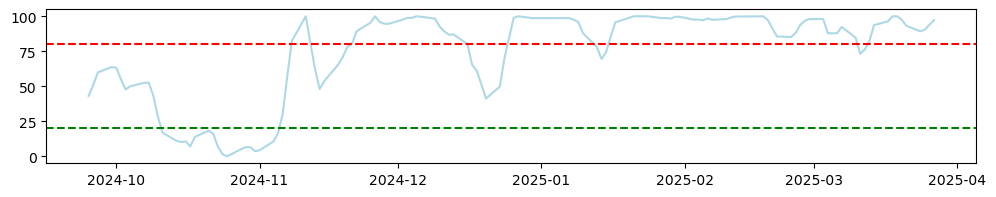

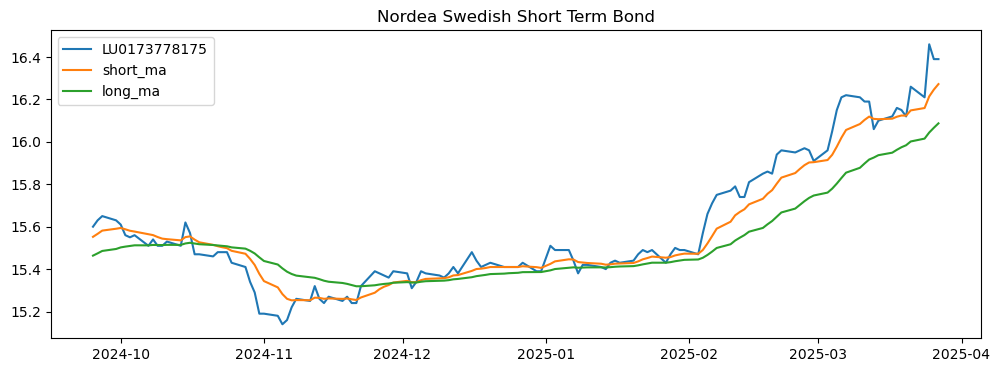

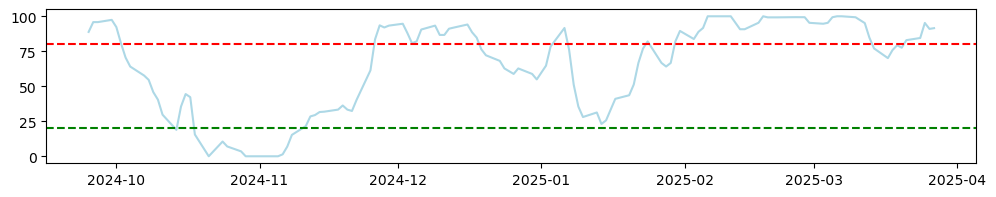

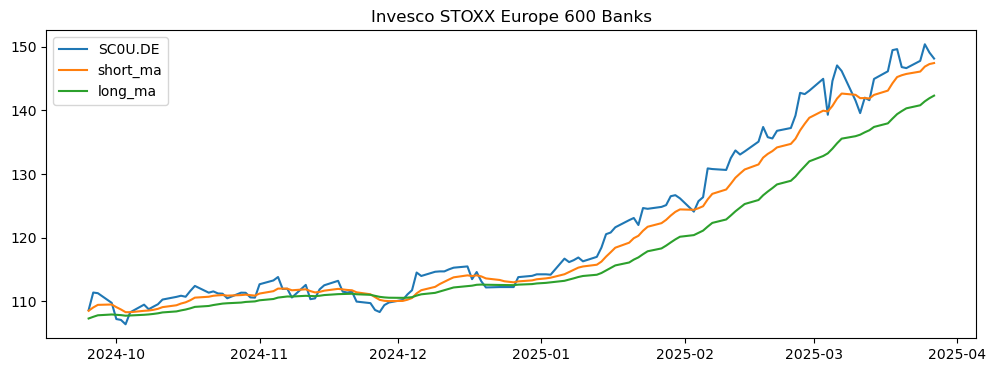

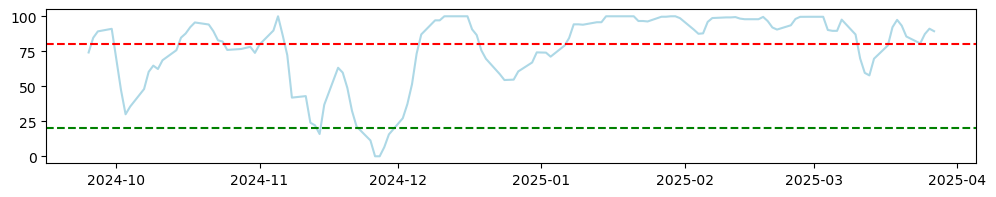

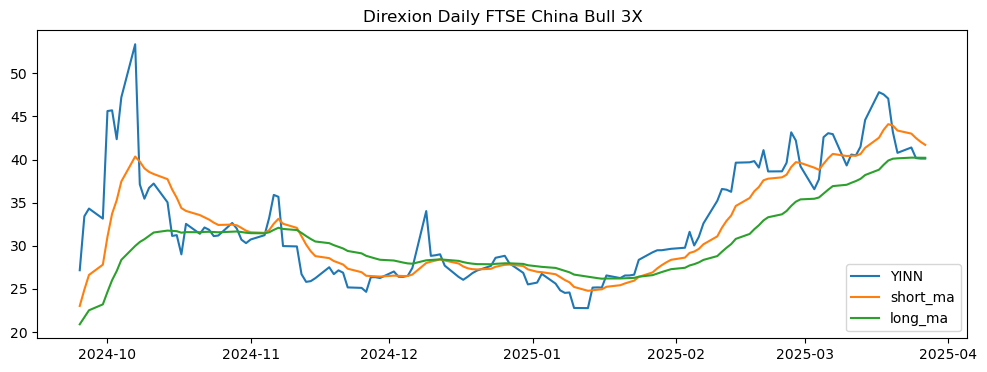

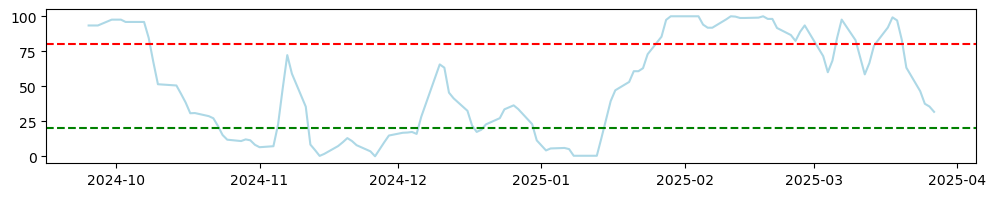

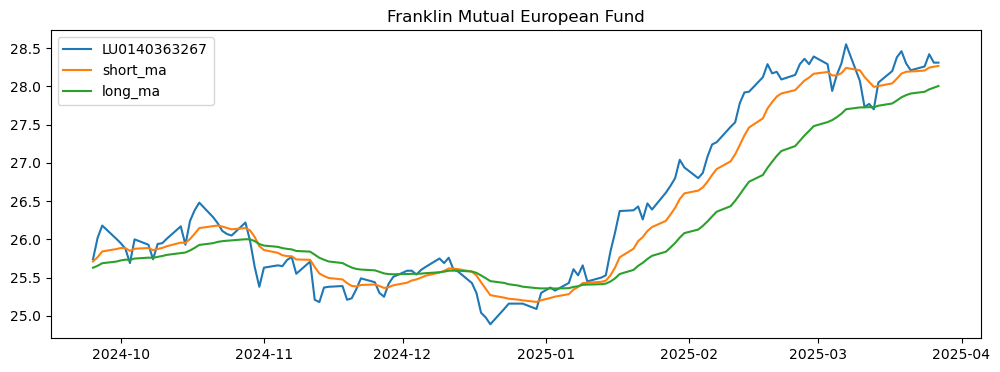

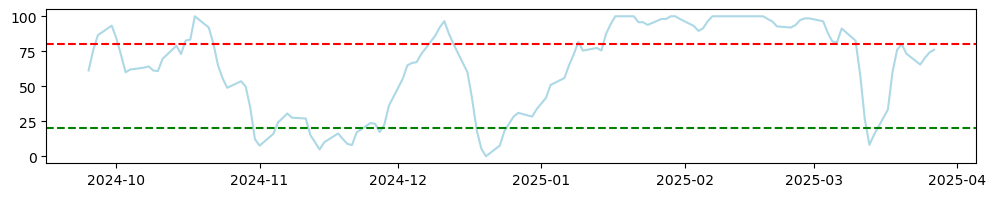

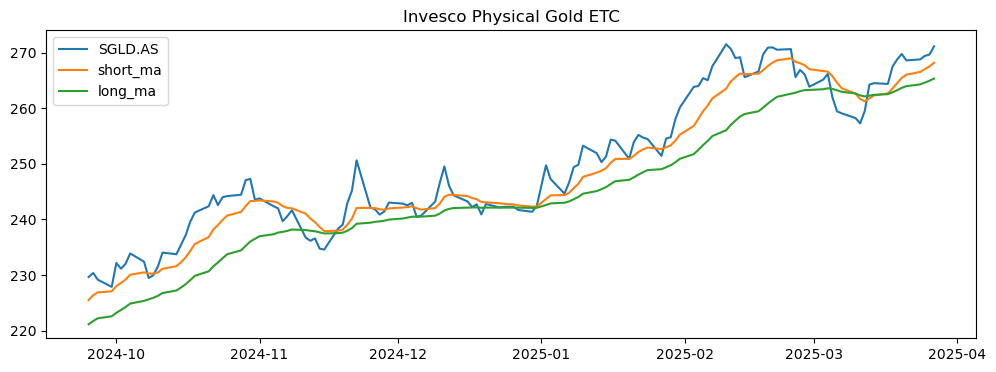

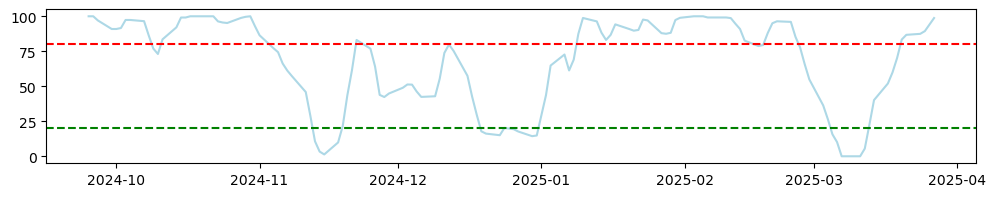

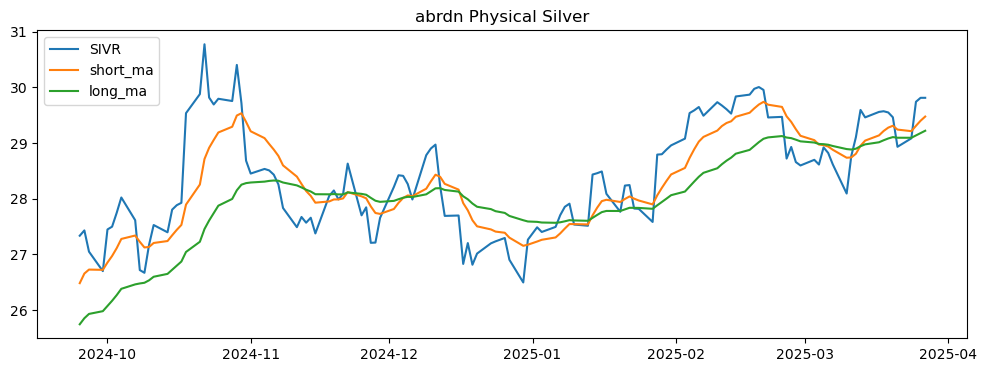

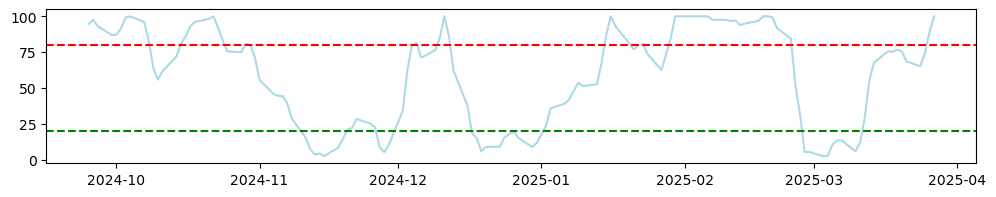

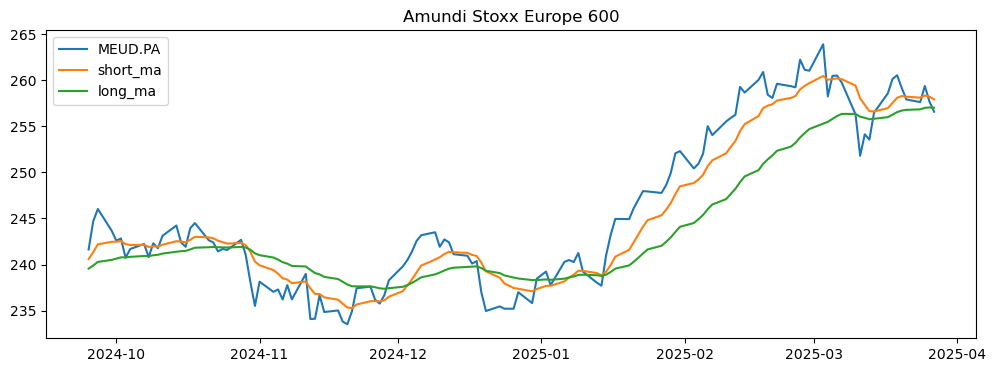

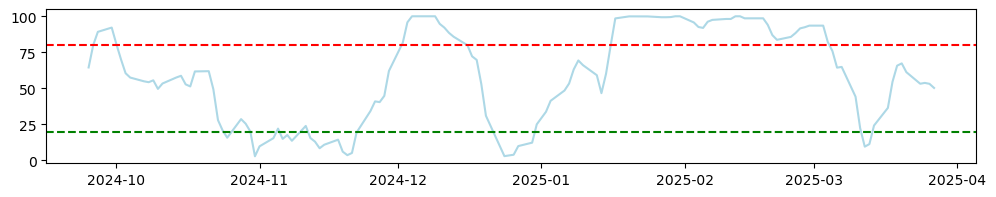

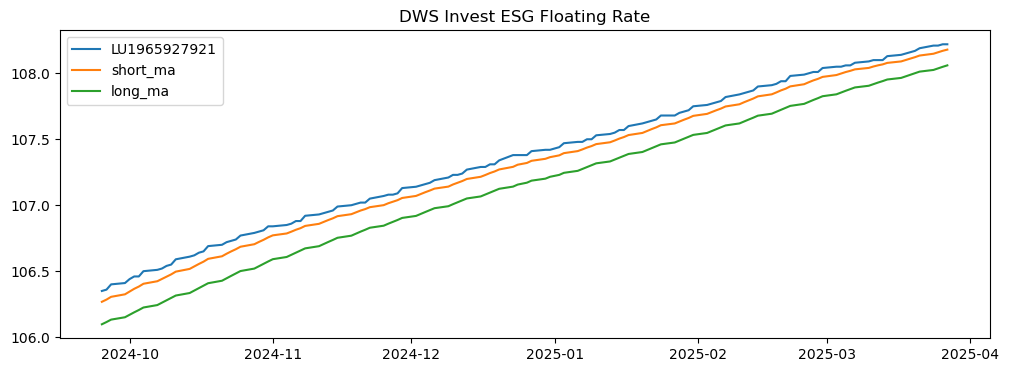

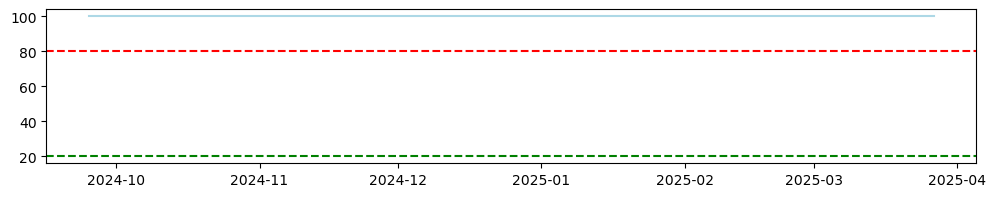

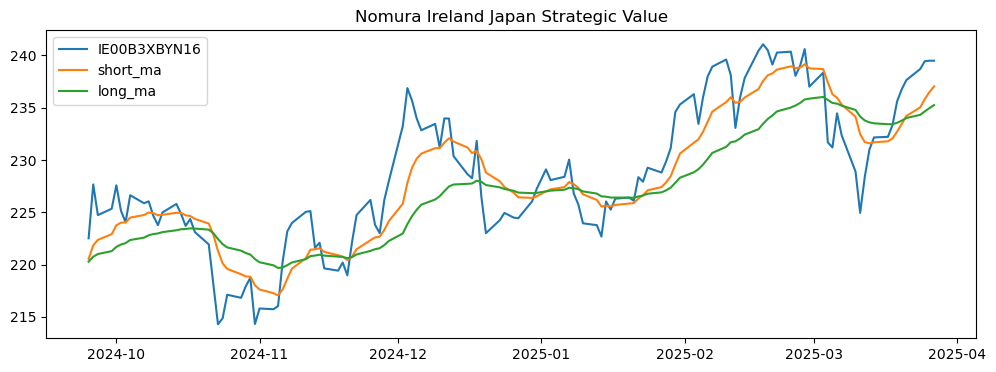

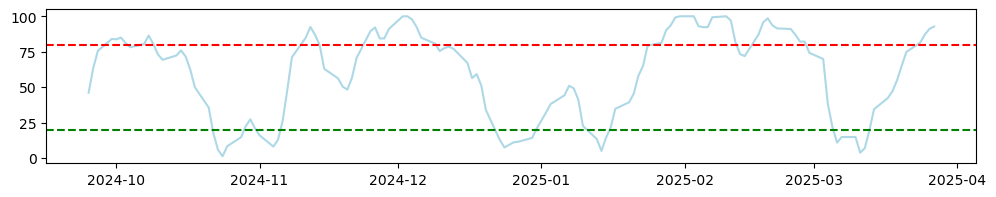

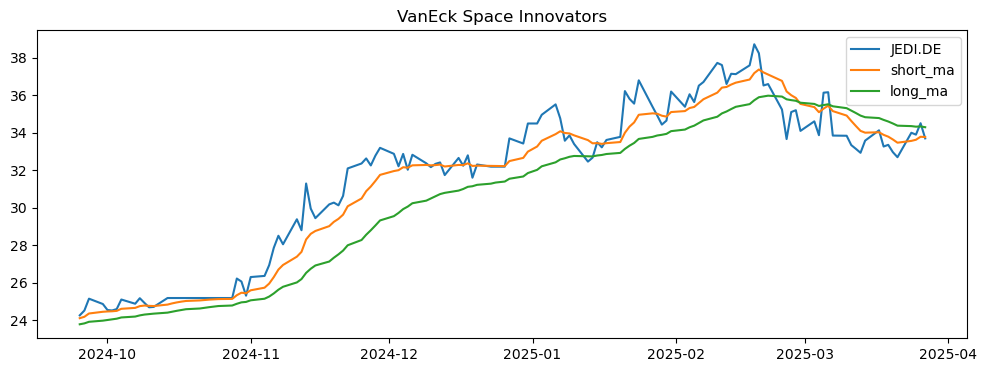

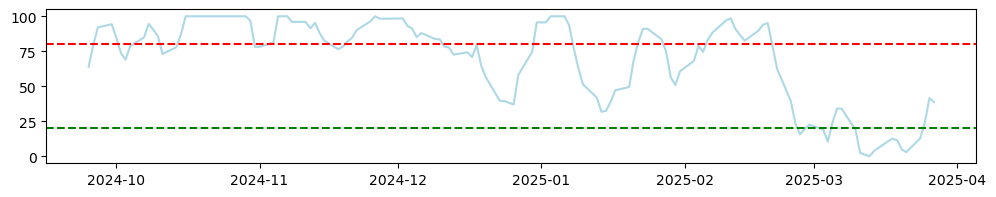

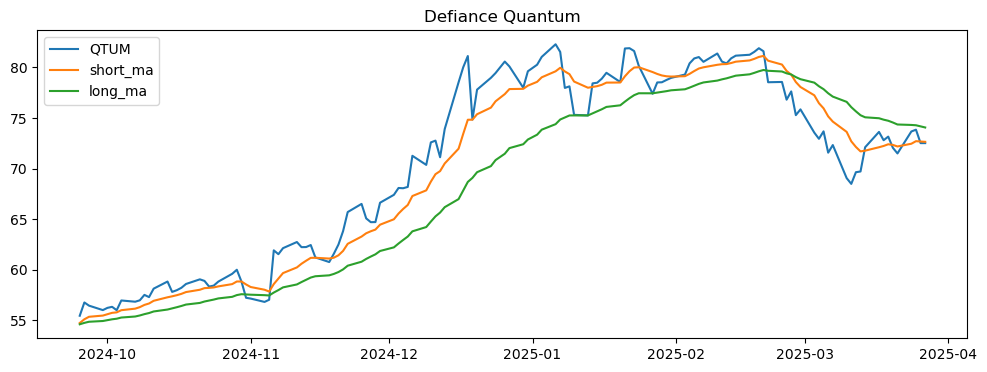

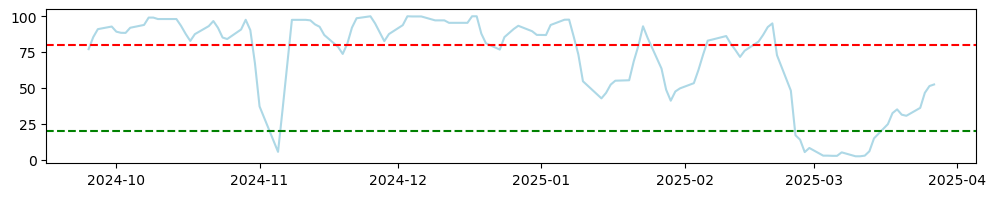

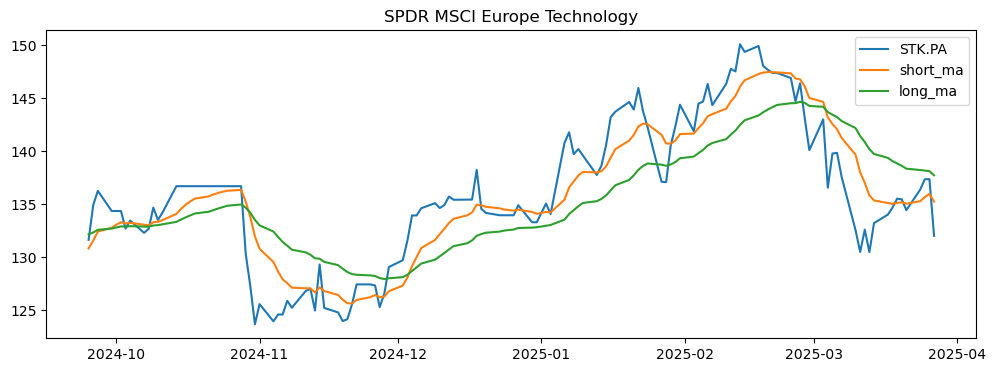

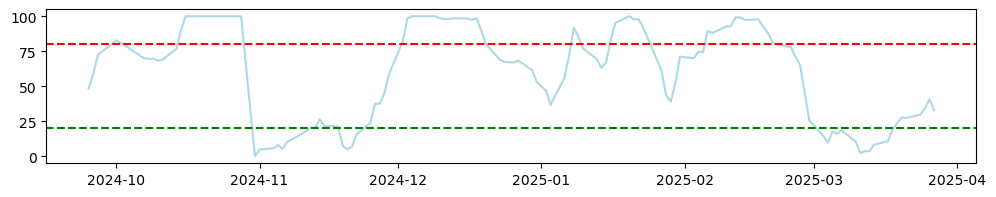

In [8]:

for symb in df_plot.index:
    print_fund_change(symb)
    plot_stochastic_oscillator(symb, period=21, smooth_k=3, smooth_d=3)

In [9]:
sell_opps(lag=5)


####################  SELL OPPS  #####################


Series([], Name: symb, dtype: object)

### Buy Opportunities

In [10]:
df_plot = df_features[df_features['Overbought Entry']].sort_values(by='Racio2',ascending=False)[:15]
df_plot

Growth       STD      Racio   D_Volat     Racio2  \
LU0130323438  0.656648  0.007968  78.645241  0.006307  60.895239   
LU0173776047  0.249687  0.004251  51.682005  0.002275  49.923183   
CD9.PA        0.340139  0.005920  52.391425  0.003802  45.868071   
LU0725142979  0.503826  0.008168  58.008745  0.006762  43.686022   
IE00B3MC6Z15  0.113541  0.002142  38.998878  0.000913  42.111790   
LU0119063039  0.407801  0.007535  50.138678  0.006140  38.130710   
XSLE.DE       0.569690  0.017165  31.441709  0.007678  33.189518   
LU2066957221  0.255731  0.005671  39.801814  0.004102  32.535995   
IE00BJ7B9456  0.070928  0.001341  30.527797  0.000978  24.827587   
LU0835716241  0.135581  0.005550  19.022072  0.004272  14.982857   
LU1353951459  0.051955  0.001331  16.492447  0.000813  14.846189   
LU0011890265  0.196559  0.010320  16.139705  0.006754  13.980792   
DFEA.L        0.133472  0.008934  11.581902  0.006446   9.481938   
LU0011889929  0.129179  0.011819   8.391535  0.008886   6.703175   
LU0447459503  0.047183  0.008523   2.016218  0.005136   1.828493   

              PricePosition  Oversold Exit  Overbought Entry  Amount EUR  
LU0130323438       0.980435          False              True         NaN  
LU0173776047       0.979730          False              True         NaN  
CD9.PA             0.983232          False              True         NaN  
LU0725142979       0.978546          False              True         NaN  
IE00B3MC6Z15       0.437775          False              True         NaN  
LU0119063039       0.959906          False              True         NaN  
XSLE.DE            0.924645          False              True         NaN  
LU2066957221       0.982544          False              True         NaN  
IE00BJ7B9456       0.985915          False              True         NaN  
LU0835716241       0.972991          False              True         NaN  
LU1353951459       0.885496          False              True         NaN  
LU0011890265       0.921243          False              True         NaN  
DFEA.L             0.940600          False              True         NaN  
LU0011889929       0.885198          False              True         NaN  
LU0447459503       0.462444          False              True         NaN

LU0130323438 


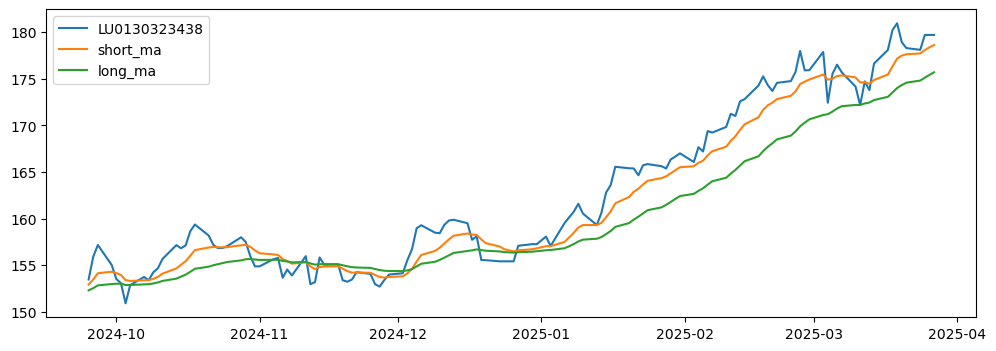

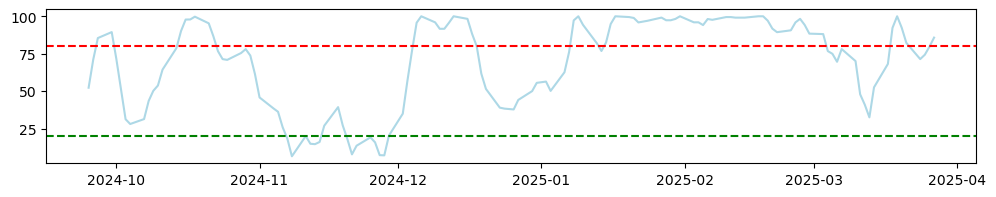

LU0173776047 


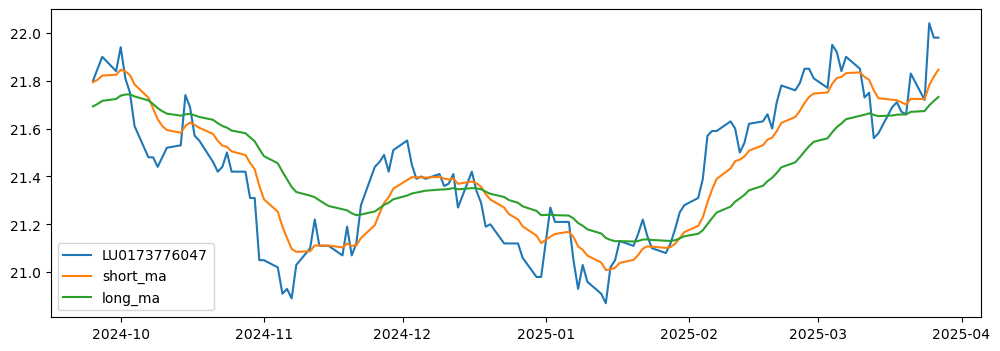

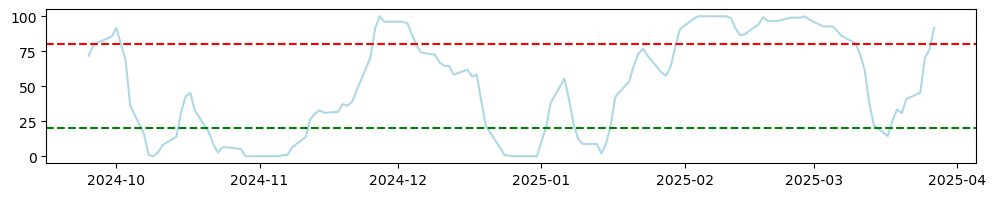

CD9.PA 


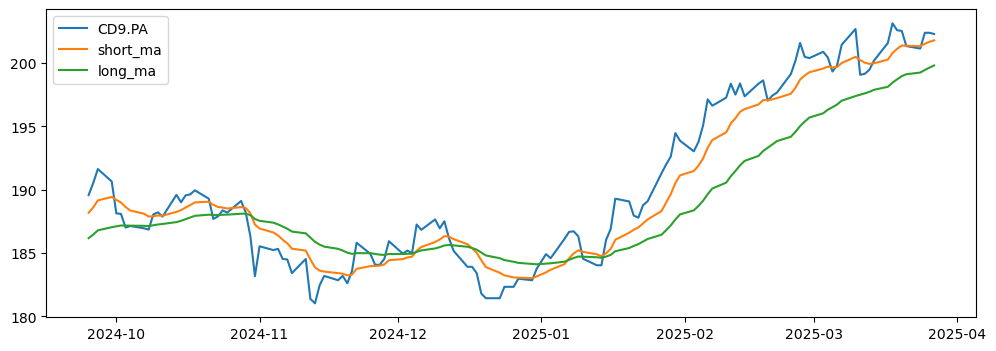

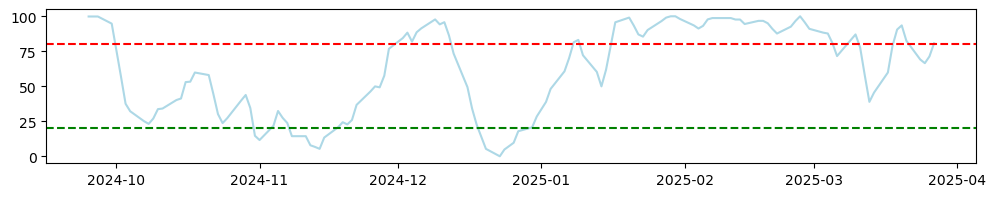

LU0725142979 


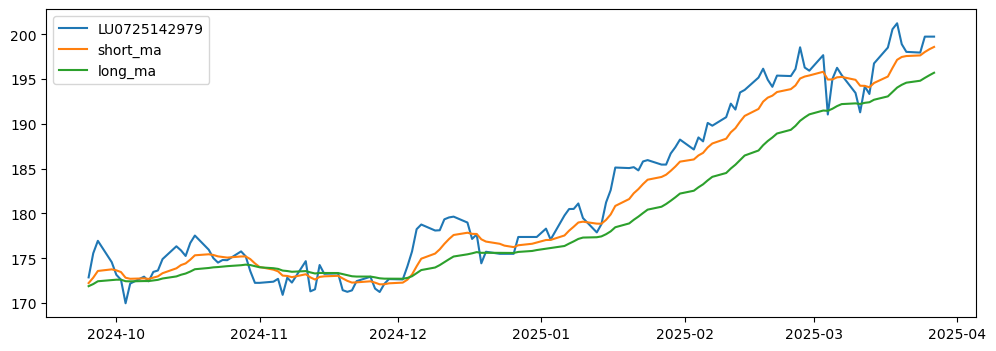

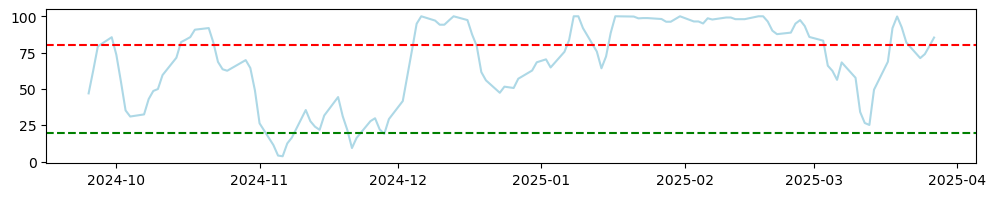

IE00B3MC6Z15 


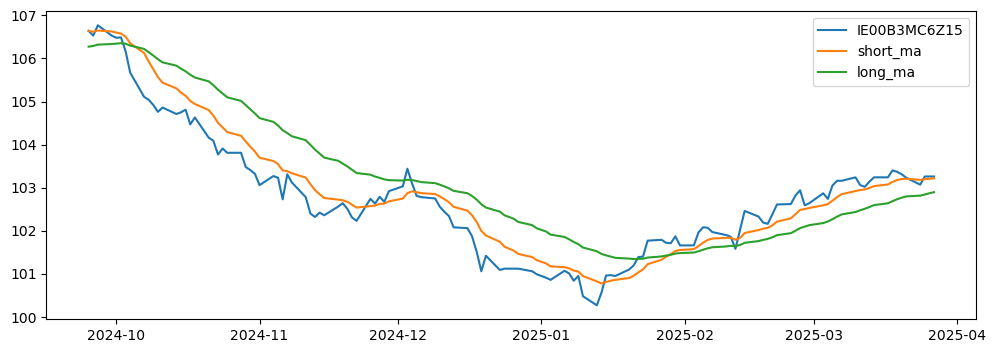

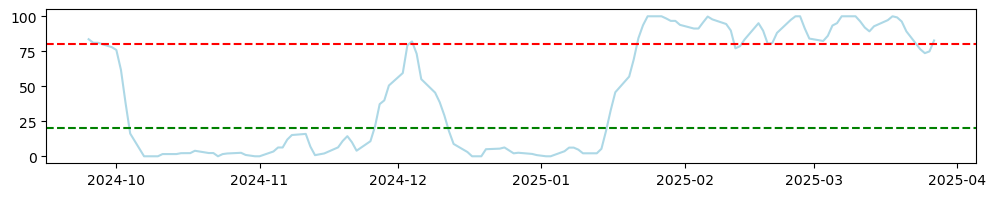

LU0119063039 


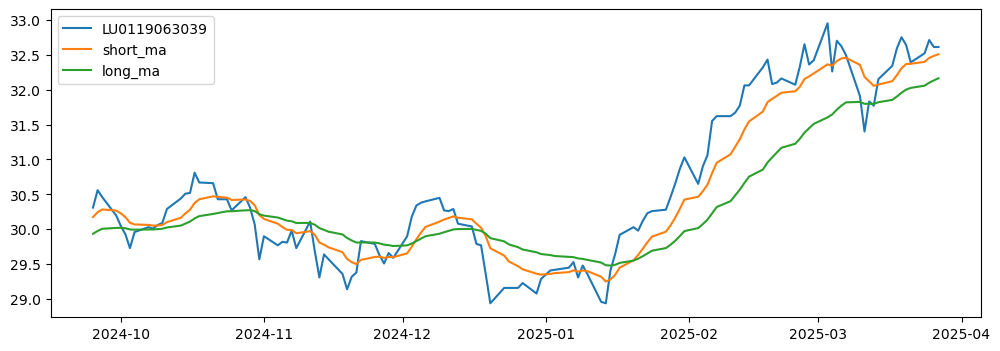

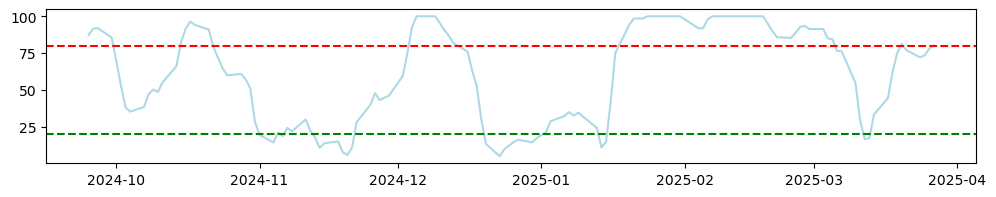

XSLE.DE 


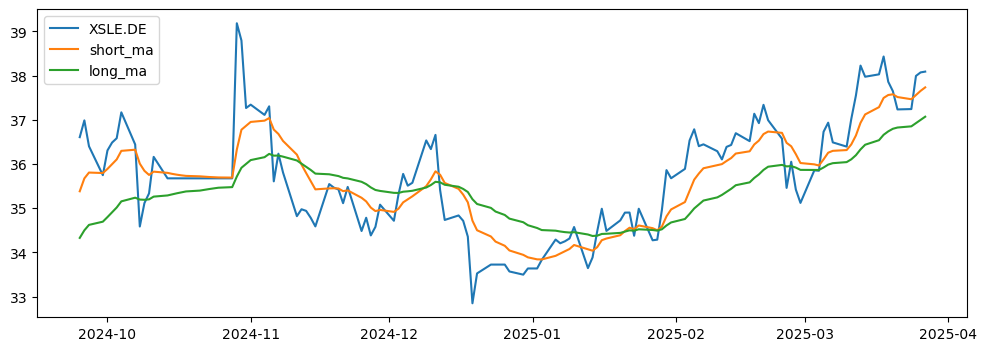

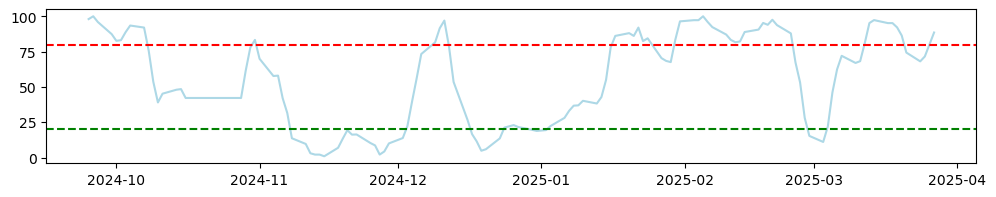

LU2066957221 


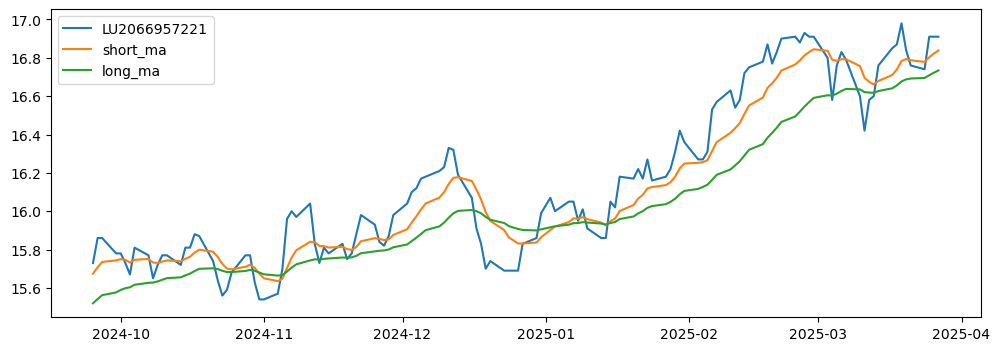

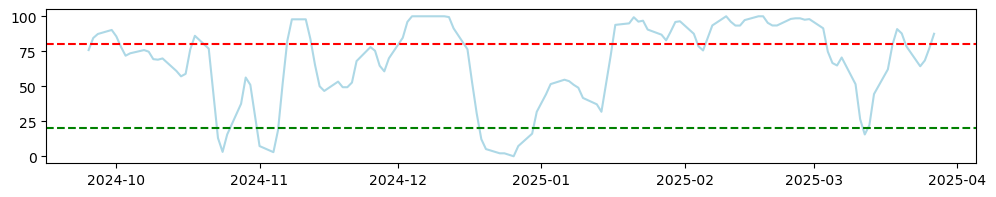

IE00BJ7B9456 


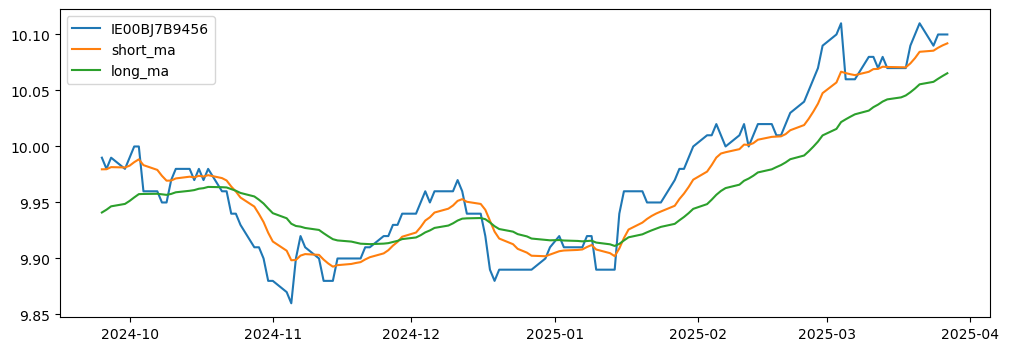

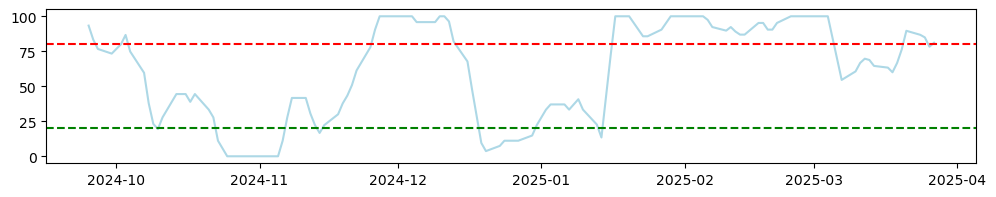

LU0835716241 


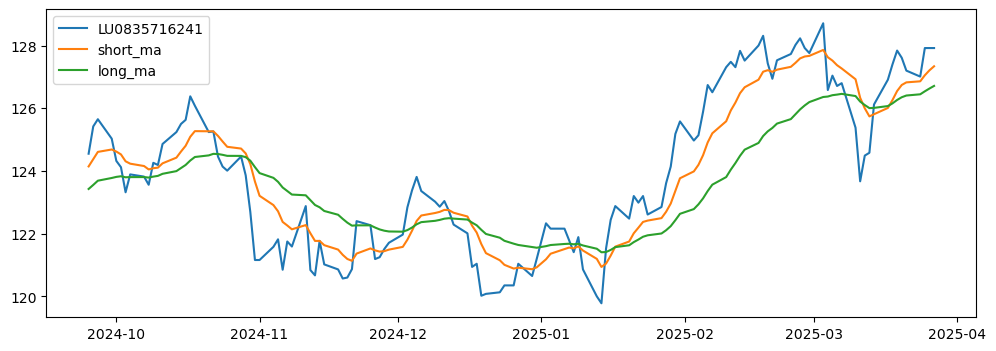

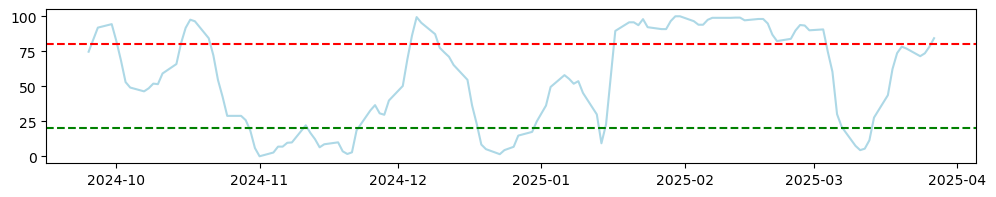

LU1353951459 


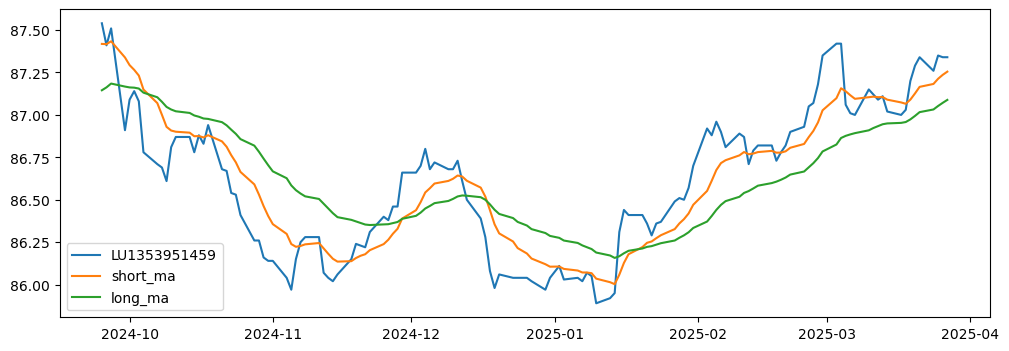

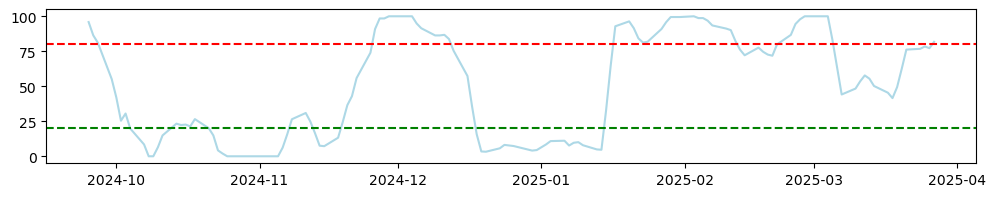

LU0011890265 


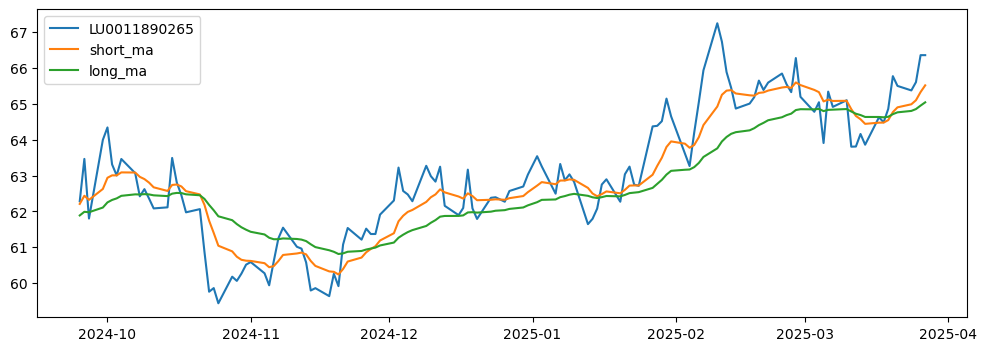

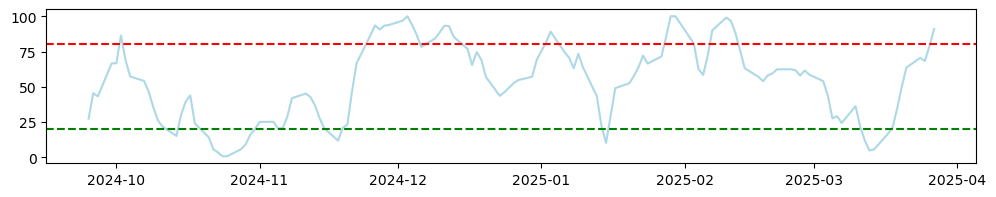

DFEA.L 


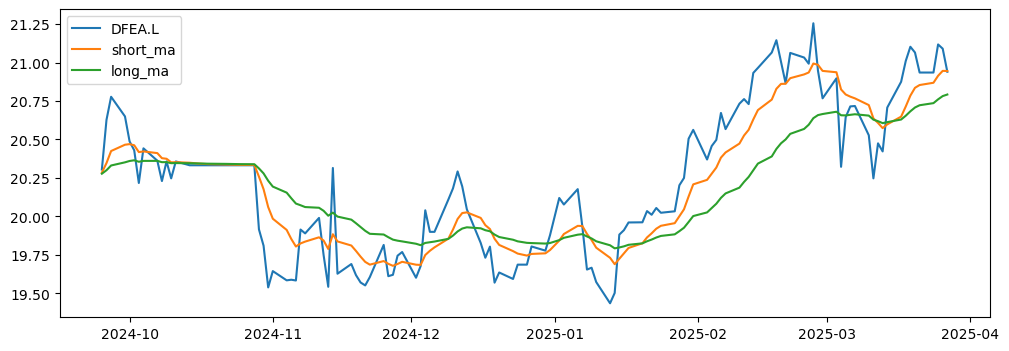

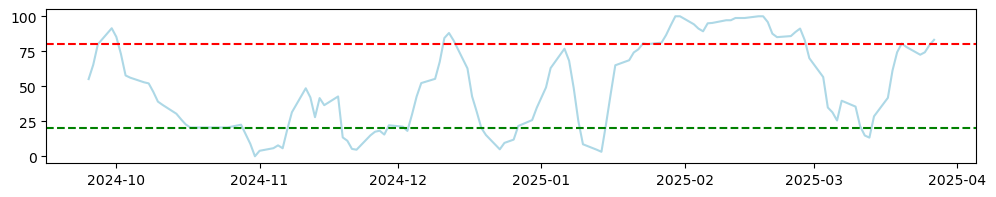

LU0011889929 


LU0447459503 


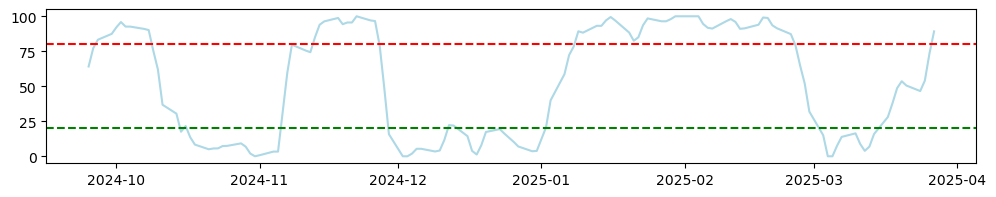

In [11]:

for symb in df_plot.index:
    print(symb,code2name_dict.get(symb,''))
    print_fund_change(symb)
    plot_stochastic_oscillator(symb, period=21, smooth_k=3, smooth_d=3)

In [12]:
fund_list = buy_opps_change_trend(lag=3,graph=False)
df_plot = df_features.loc[fund_list].sort_values(by='Racio2',ascending=False)[:15]
df_plot

####################  BUY OPPS  #####################


C:\Users\DUARTEMário\AppData\Local\Temp\ipykernel_22772\1908787563.py:18: RuntimeWarning: invalid value encountered in scalar divide
  price_position = (ts.iloc[-1]-ts_min)/(ts_max-ts_min)


Growth       STD      Racio   D_Volat     Racio2  \
LU1984220373  0.215917  0.009040  20.565335  0.007870  15.005418   
LU0164853813  0.194771  0.009553  17.248531  0.008311  12.590032   
LU0109402221  0.155877  0.009066  13.885170  0.007347  10.596079   
LU0188151921  0.150977  0.008686  13.928249  0.007135  10.539681   
IUES.L        0.237023  0.014761  14.024661  0.013085  10.115423   
HAP           0.128822  0.009113  10.844598  0.006086   9.286200   
LU0611395673  0.139503  0.009345  11.717920  0.007533   8.971890   
XLE           0.196488  0.014741  11.294002  0.011593   8.779411   
SLX           0.166222  0.015419   8.834720  0.010305   7.561780   
LU0122377152  0.169607  0.013091  10.664563  0.012685   7.259592   
UE24.AS       0.111971  0.008262   9.921337  0.007274   7.187469   
SXLE.AS       0.165512  0.014238   9.517510  0.012468   6.918563   
LU0347592353  0.102759  0.008186   8.888344  0.006794   6.683260   
XUEN.DE       0.154915  0.014279   8.747873  0.012226   6.450260   
LU0211332217  0.085806  0.007068   7.895159  0.005625   6.092826   

              PricePosition  Oversold Exit  Overbought Entry  Amount EUR  
LU1984220373       0.792832          False             False         NaN  
LU0164853813       0.843982          False             False         NaN  
LU0109402221       0.809080          False             False         NaN  
LU0188151921       0.808333          False             False         NaN  
IUES.L             0.779961          False             False         NaN  
HAP                0.649982          False             False         NaN  
LU0611395673       0.880145          False             False         NaN  
XLE                0.695046          False             False         NaN  
SLX                0.293950          False             False         NaN  
LU0122377152       0.753332          False             False         NaN  
UE24.AS            0.919804          False             False         NaN  
SXLE.AS            0.746745          False             False         NaN  
LU0347592353       0.850251          False             False         NaN  
XUEN.DE            0.671926          False             False         NaN  
LU0211332217       0.902928          False             False         NaN

LU1984220373 


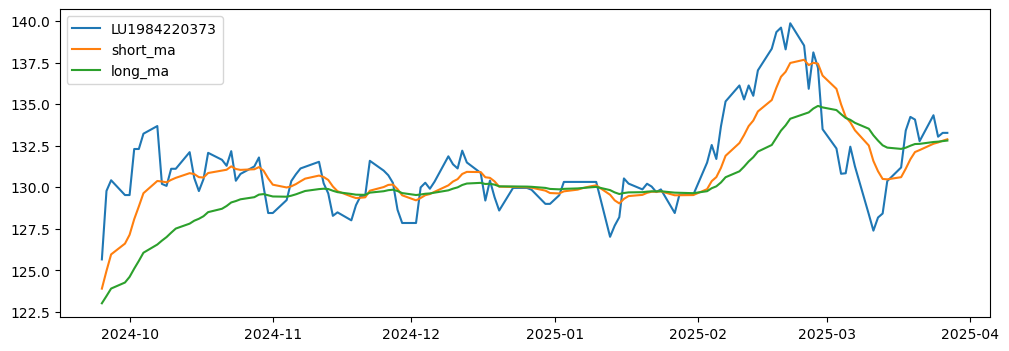

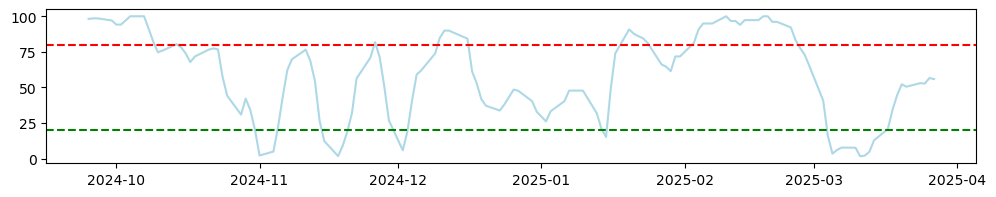

LU0164853813 


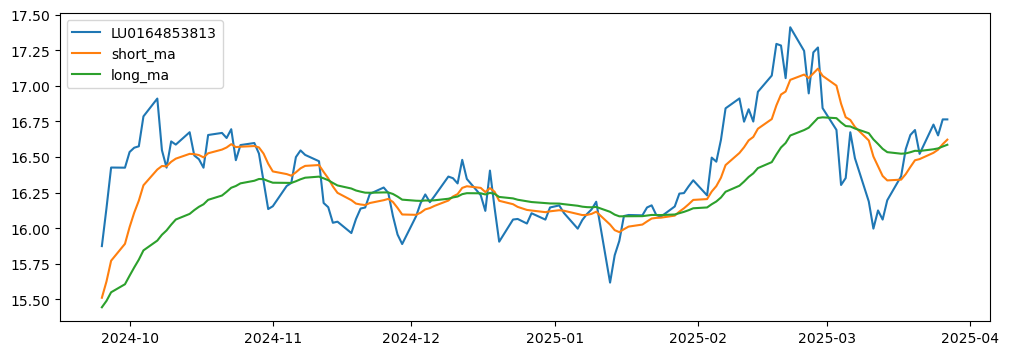

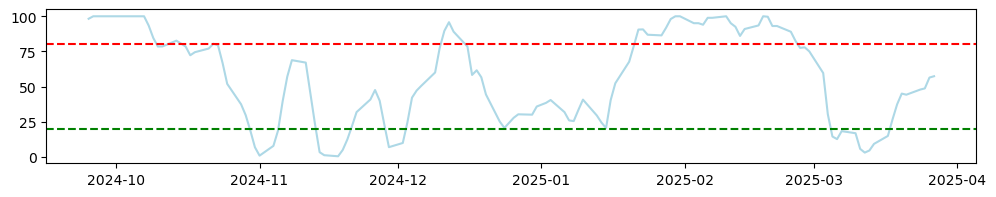

LU0109402221 


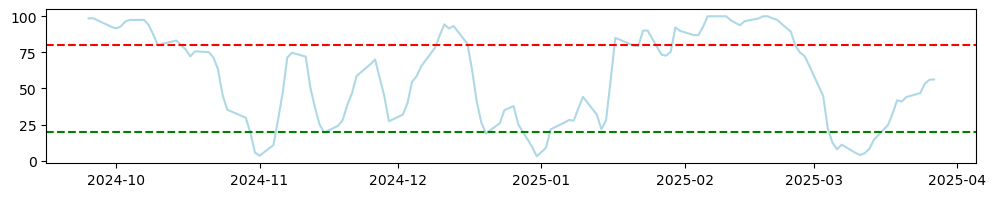

LU0188151921 


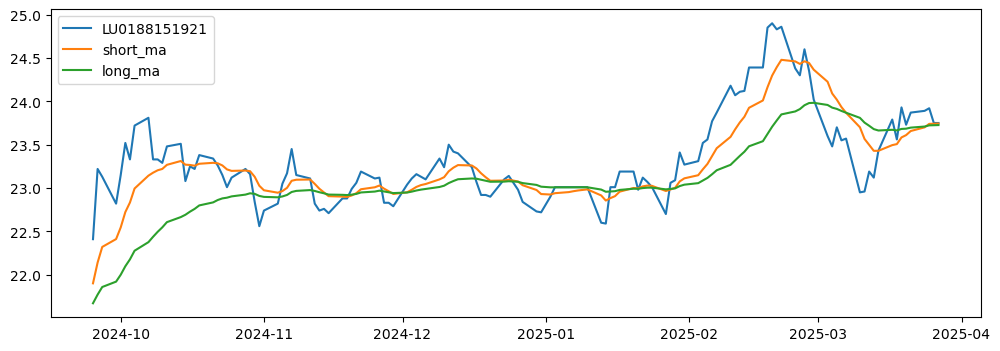

IUES.L 


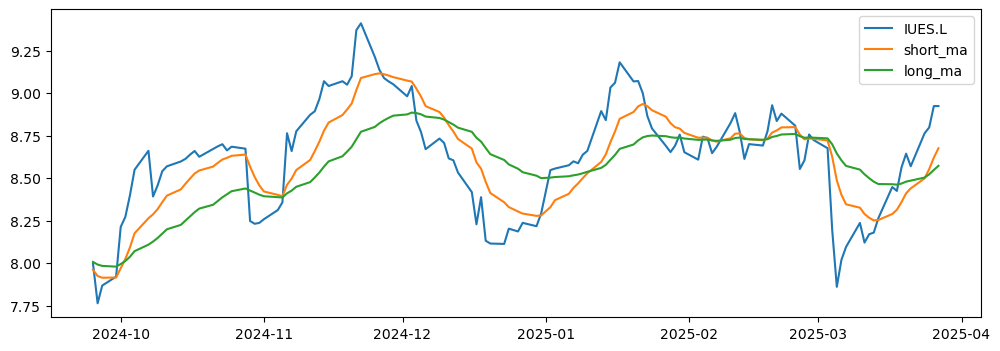

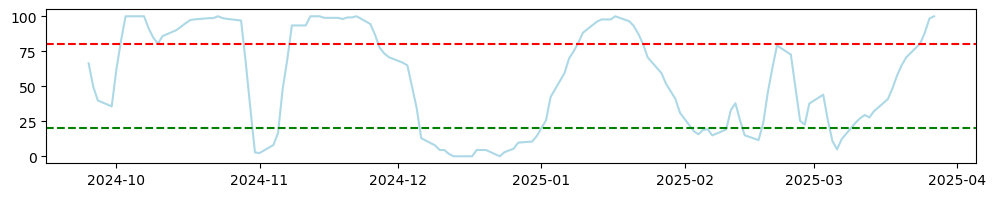

HAP 


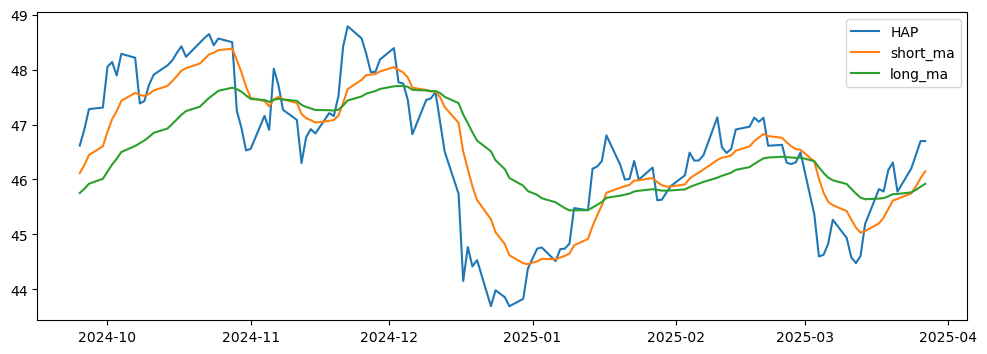

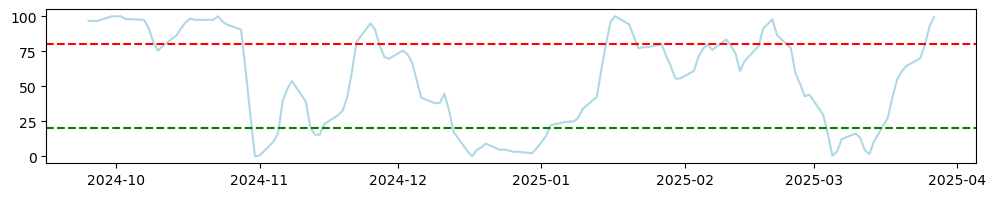

LU0611395673 


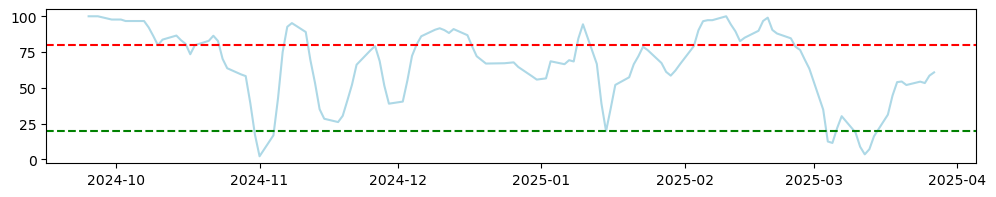

XLE 


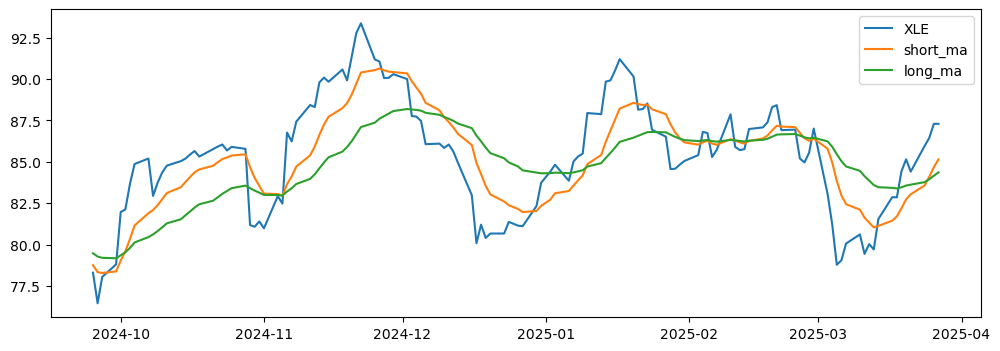

SLX 


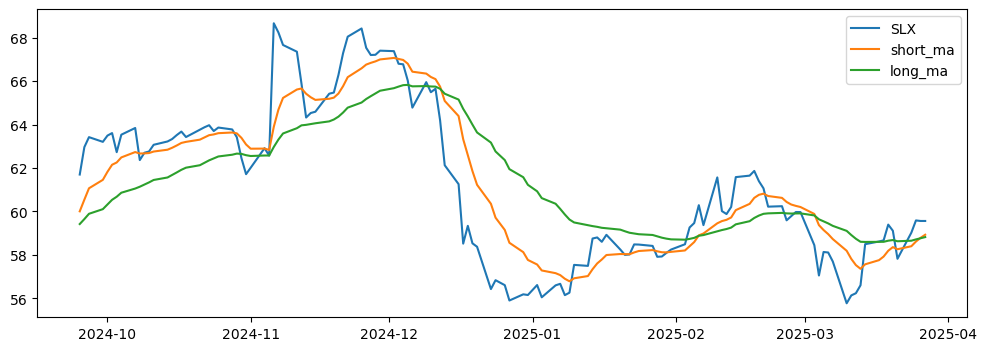

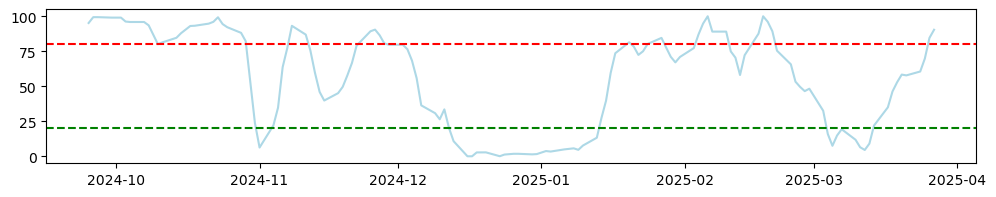

LU0122377152 


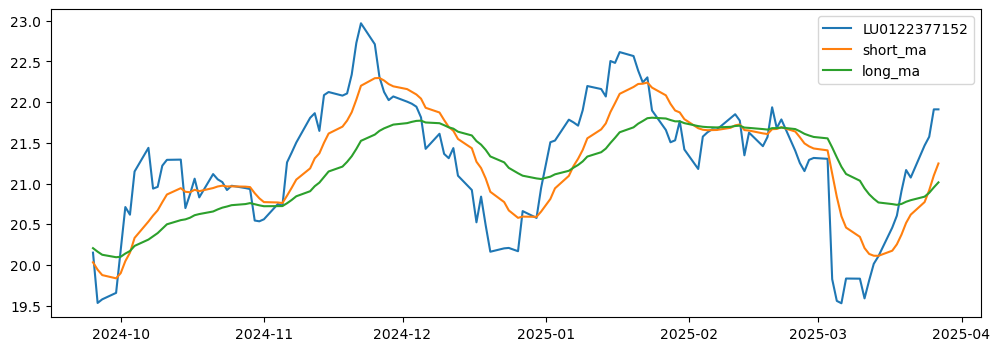

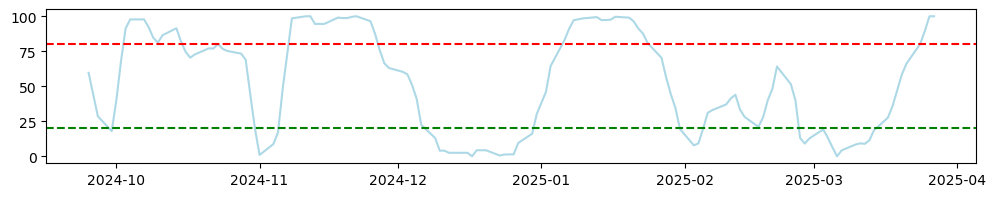

UE24.AS 


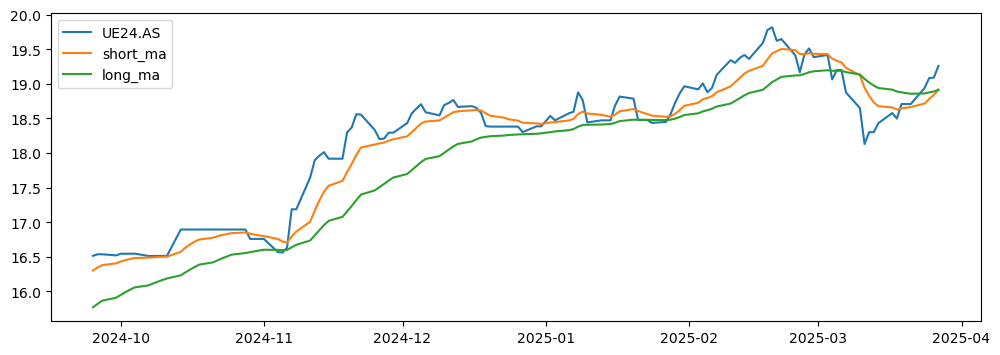

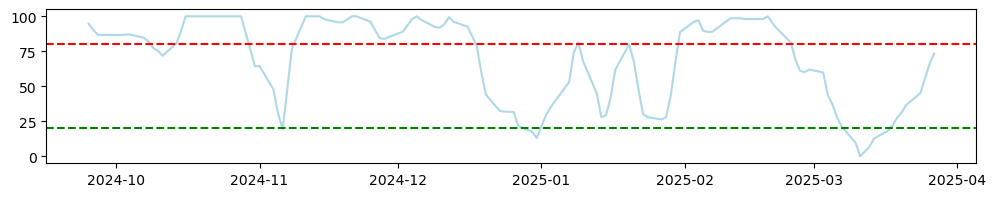

SXLE.AS 


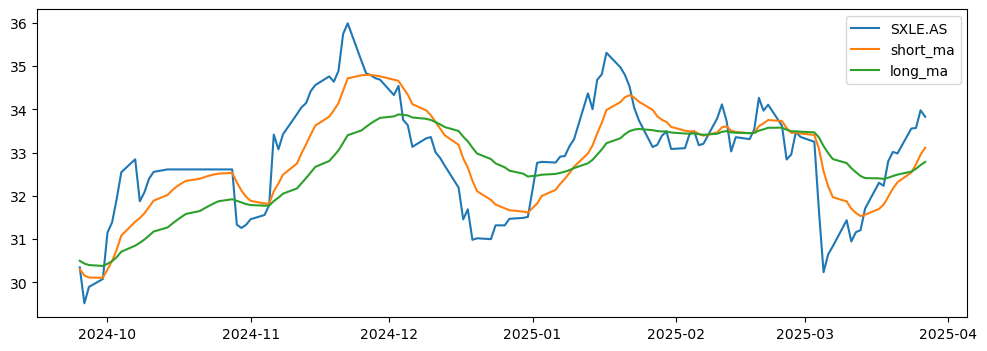

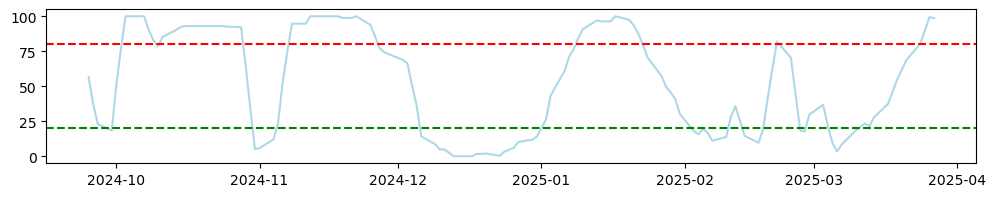

LU0347592353 


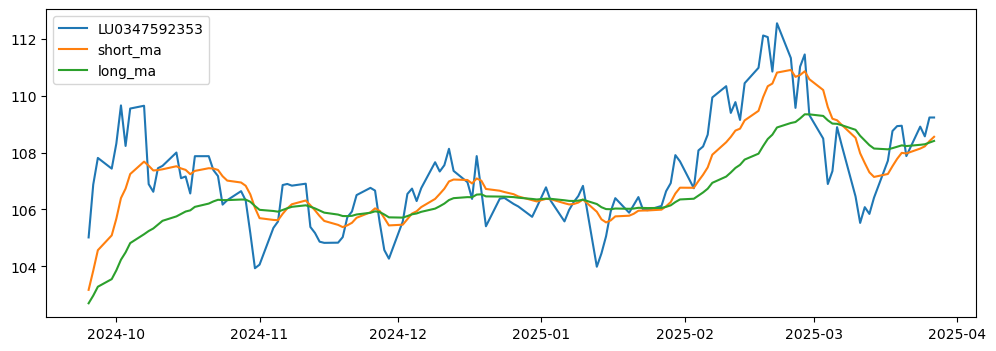

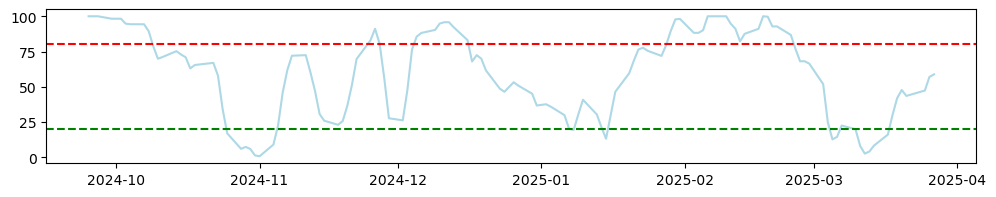

XUEN.DE 


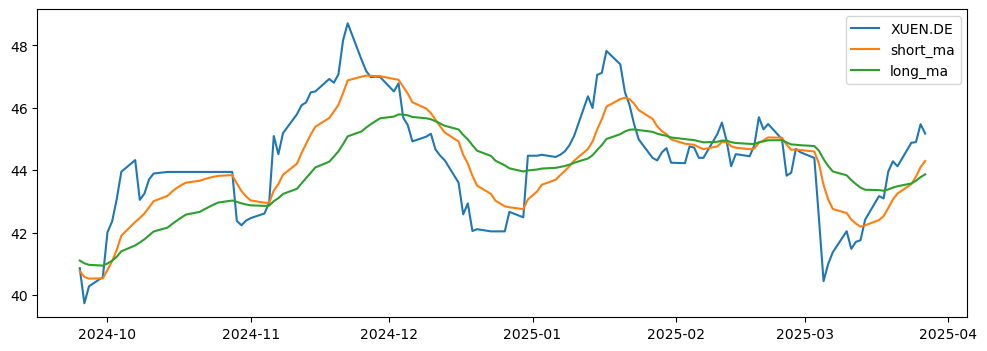

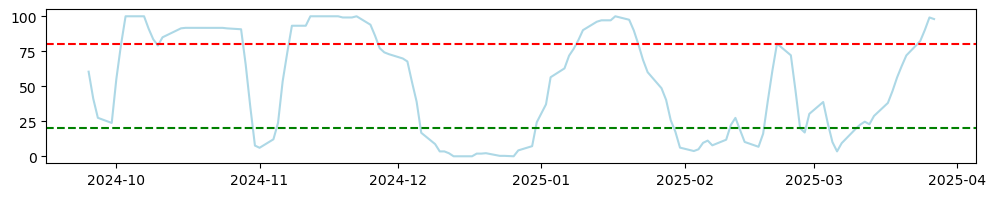

LU0211332217 


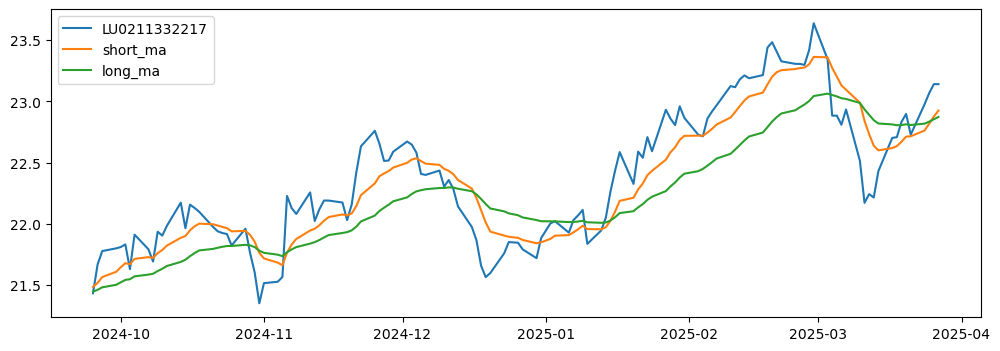

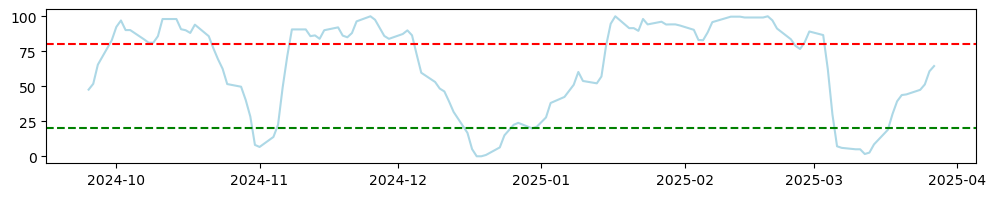

In [13]:

for symb in df_plot.index:
    print(symb,code2name_dict.get(symb,''))
    print_fund_change(symb)
    plot_stochastic_oscillator(symb, period=21, smooth_k=3, smooth_d=3)

In [25]:
def normalize(ds: pd.Series) -> pd.Series:
    # Calculate the IQR to detect high outliers
    Q1 = ds.quantile(0.25)
    Q3 = ds.quantile(0.75)
    IQR = Q3 - Q1

    # Define upper bound for high outliers (outliers above this value will be removed)
    upper_bound = Q3 + 100 * IQR

    # Filter data: keep values below the upper bound
    return ds[ds <= upper_bound]

df_filter = df_features.index.isin(normalize(df_features['STD']).index) & (df_features['Growth']>0.07) & (df_features['Growth']<0.2)
#df_filter = df_features.index.isin(normalize(df_features['STD']).index) & (df_features['Growth']>=0.08) & (df_features['Growth']<0.25)
#df_filter = df_features.index.isin(normalize(df_features['STD']).index) & (df_features['D_Volat']>0.0005)
#df_filter =  (df_features['Growth']>=.2) #& (df_features['Growth']<0.07)

df_plot = df_features[df_filter].sort_values(by=['PricePosition', 'Racio2'], ascending=[False, False]).head(15)
df_plot

Growth       STD      Racio   D_Volat     Racio2  \
LU0705071453  0.195988  0.002933  56.586290  0.001785  51.048471   
LU1520759108  0.144220  0.003279  34.835873  0.001640  34.826943   
LU0922333165  0.115102  0.002748  30.966866  0.002332  22.963466   
IE00B5648R31  0.191955  0.008769  18.468668  0.005954  15.665278   
LU0945156023  0.187147  0.008513  18.460210  0.006478  14.639851   
LU0230817339  0.162922  0.009461  14.049497  0.006874  11.454314   
LU0654954816  0.092515  0.002837  22.031970  0.001133  24.502326   
IE00BJ7B9456  0.070928  0.001341  30.527797  0.000978  24.827587   
LU0736563114  0.091451  0.001412  43.506935  0.000591  47.382144   
LU0607518205  0.076699  0.001342  34.804525  0.000575  37.473067   
LU0622306818  0.085445  0.001455  38.113806  0.000810  36.068282   
LU0512128355  0.085001  0.001654  33.247657  0.001172  27.508826   
LU1706560247  0.071194  0.001629  25.290317  0.000964  23.161848   
IE00B3XBYN16  0.129062  0.009416  10.521164  0.007796   7.922367   
LU0992632538  0.080381  0.001444  34.898693  0.000983  29.546555   

              PricePosition  Oversold Exit  Overbought Entry    Amount EUR  
LU0705071453       1.000000          False             False           NaN  
LU1520759108       1.000000          False             False           NaN  
LU0922333165       1.000000          False             False           NaN  
IE00B5648R31       1.000000          False             False           NaN  
LU0945156023       1.000000          False             False           NaN  
LU0230817339       1.000000          False             False           NaN  
LU0654954816       0.988372          False             False           NaN  
IE00BJ7B9456       0.985915          False              True           NaN  
LU0736563114       0.976654          False             False           NaN  
LU0607518205       0.976331          False             False           NaN  
LU0622306818       0.975875          False             False           NaN  
LU0512128355       0.974982          False             False           NaN  
LU1706560247       0.974753          False             False           NaN  
IE00B3XBYN16       0.973595          False             False  14562.505297  
LU0992632538       0.973256          False             False           NaN

LU0705071453 


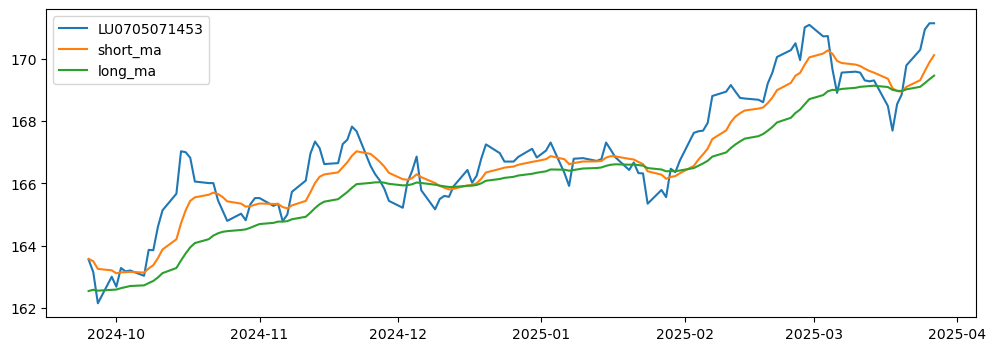

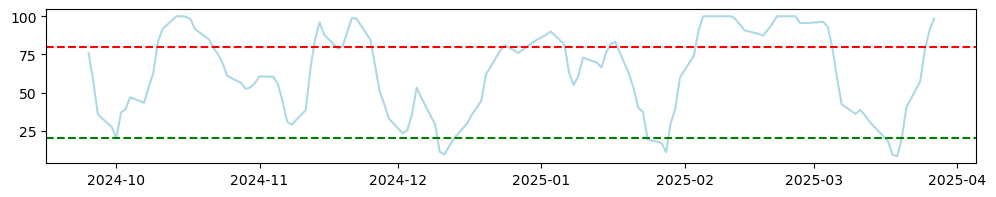

LU1520759108 


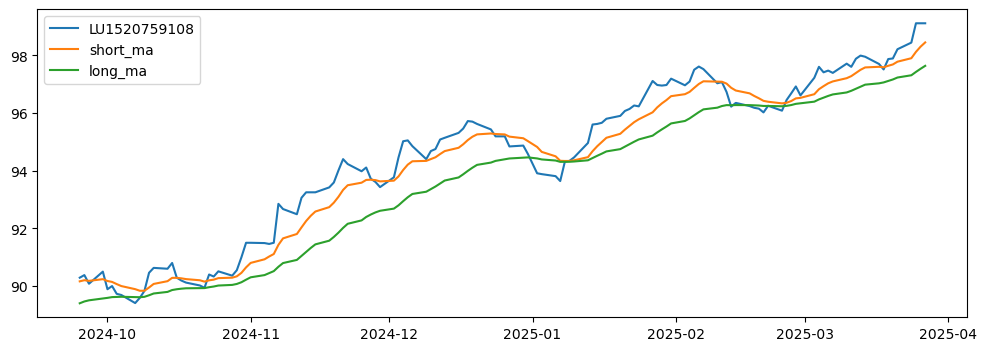

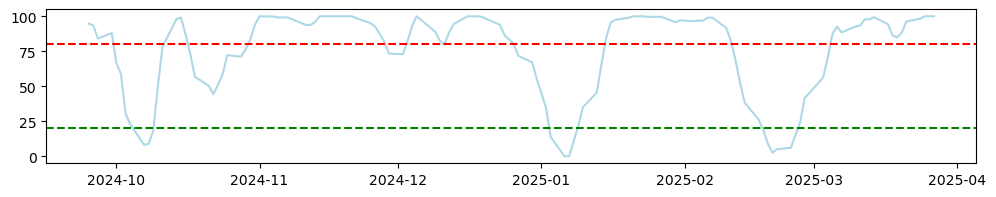

LU0922333165 


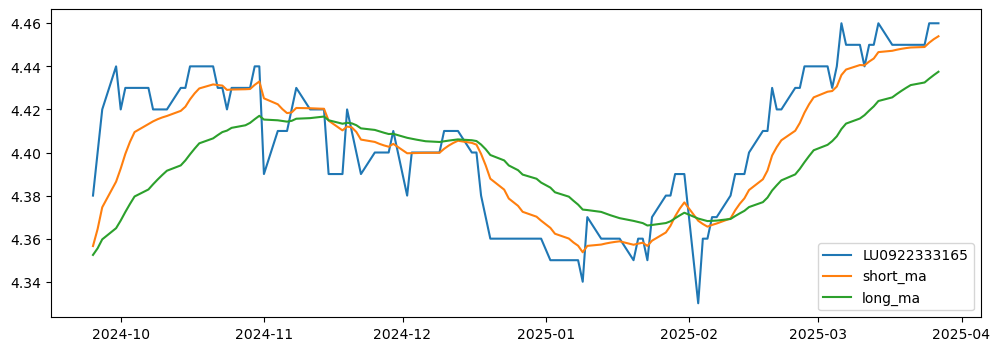

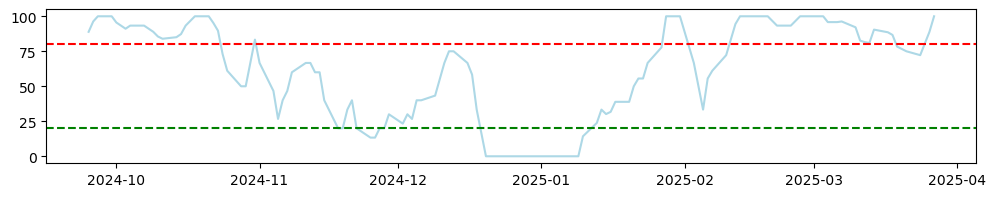

IE00B5648R31 


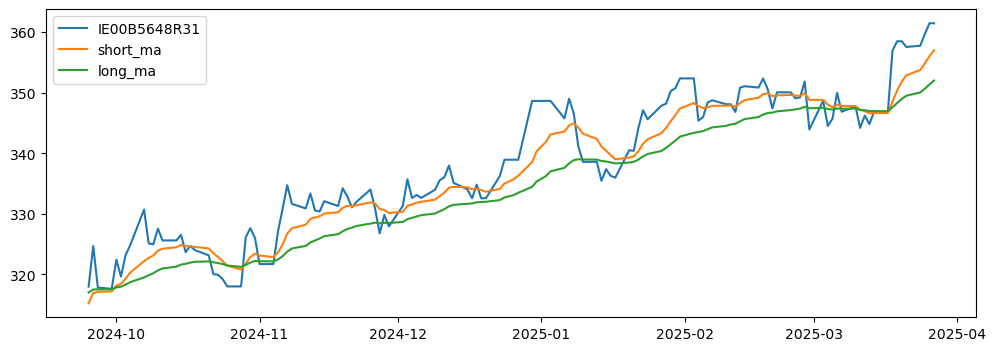

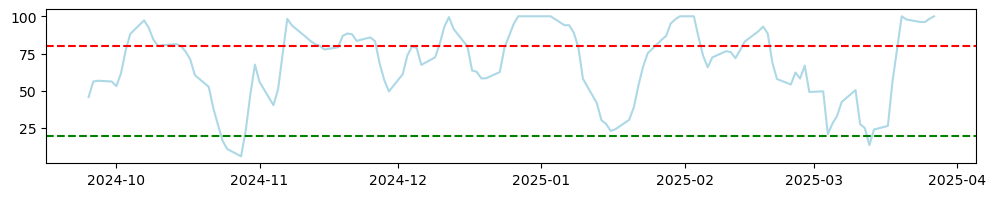

LU0945156023 


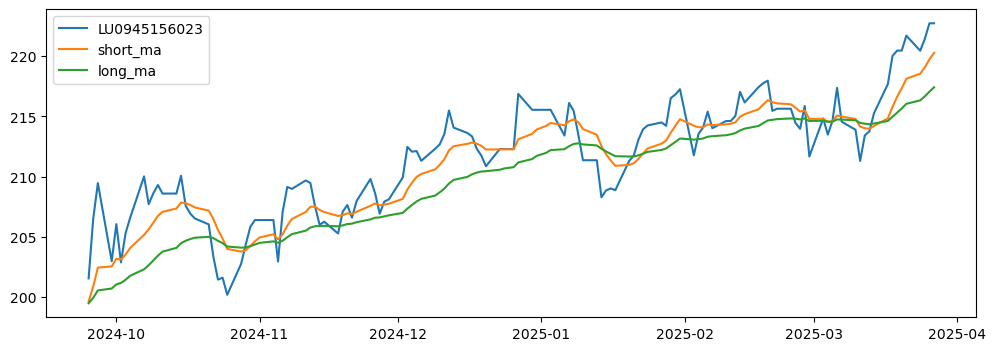

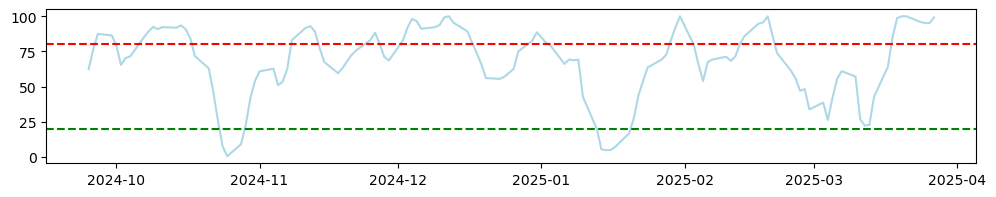

LU0230817339 


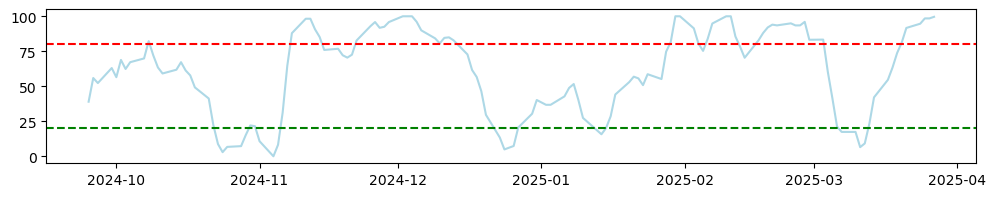

LU0654954816 


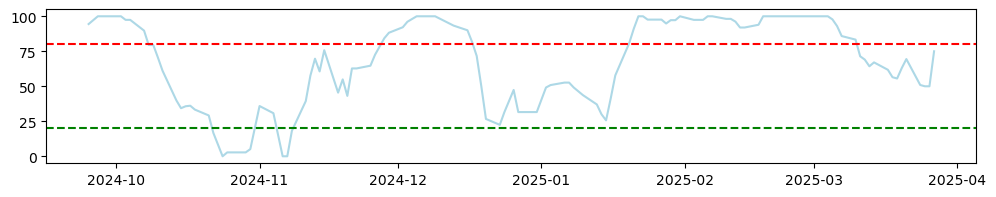

IE00BJ7B9456 


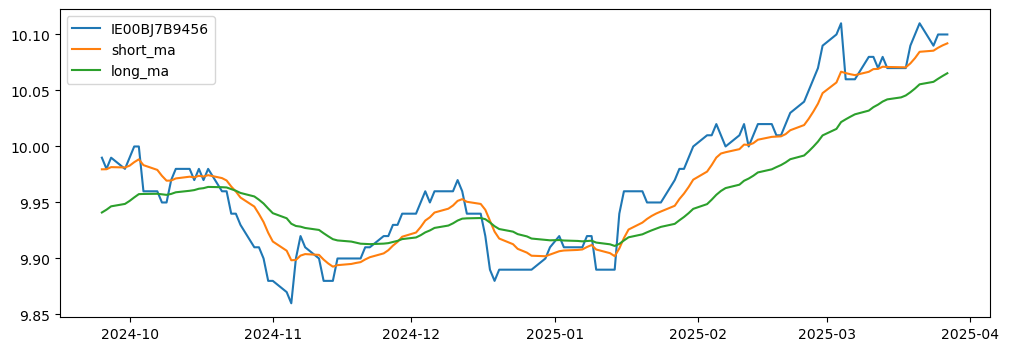

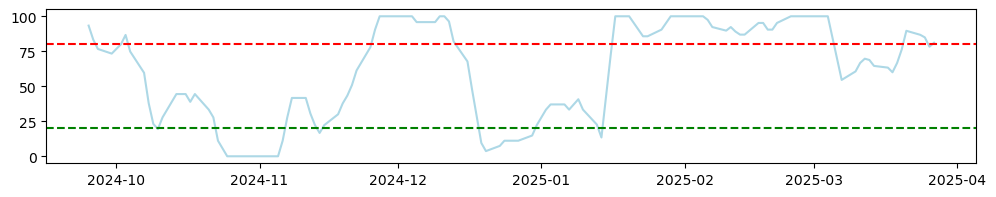

LU0736563114 


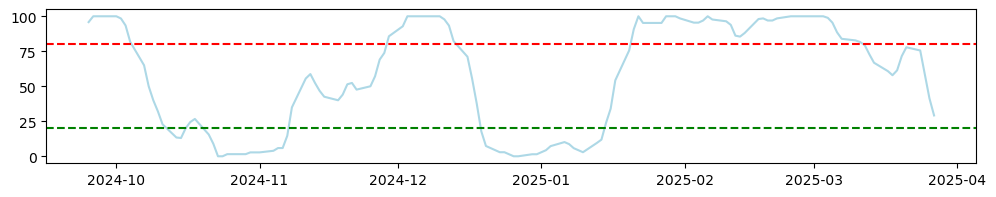

LU0607518205 


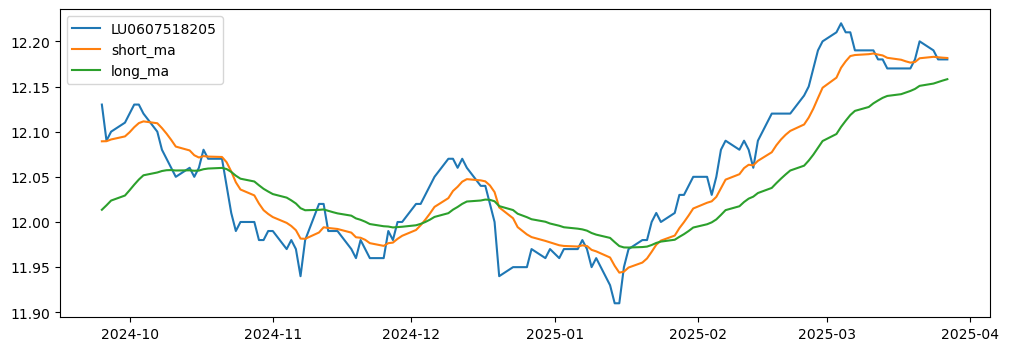

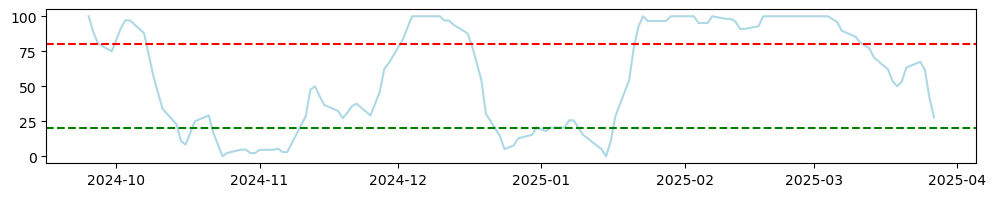

LU0622306818 


LU0512128355 


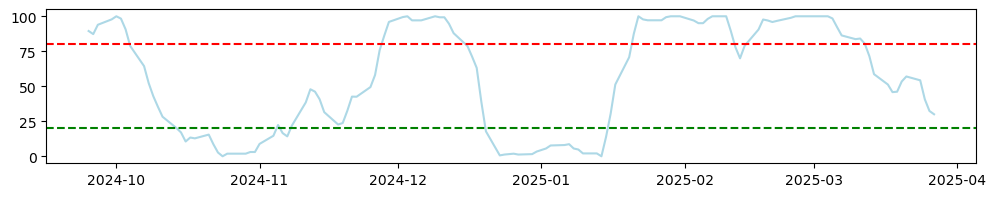

LU1706560247 


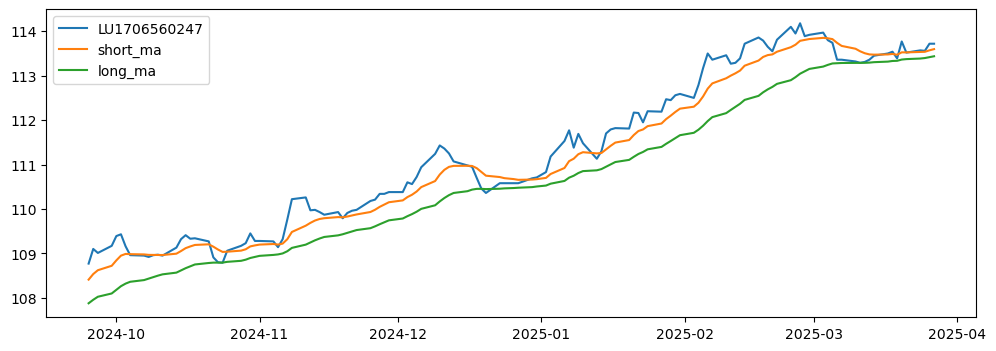

IE00B3XBYN16 Nomura Ireland Japan Strategic Value


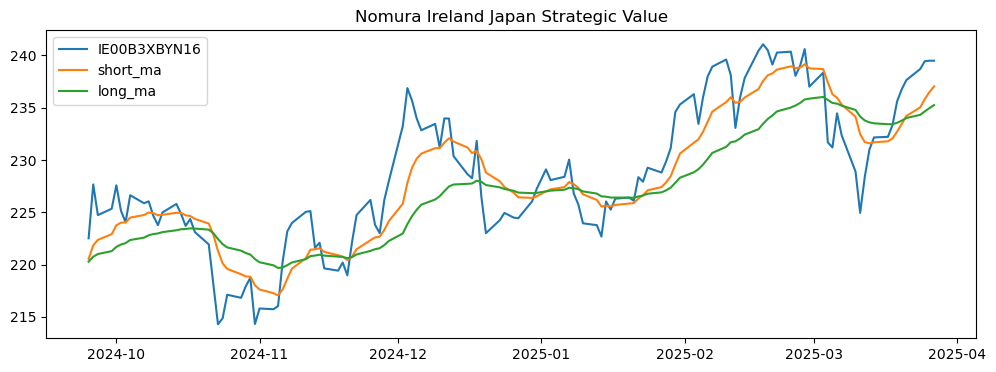

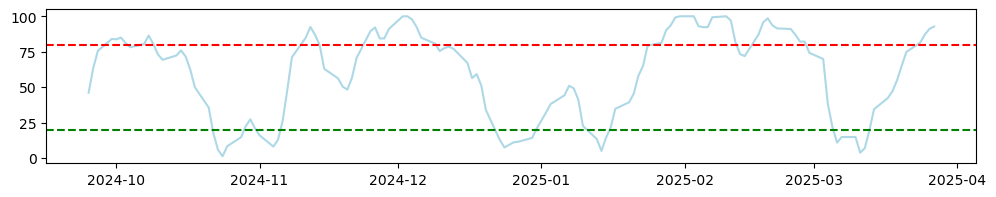

LU0992632538 


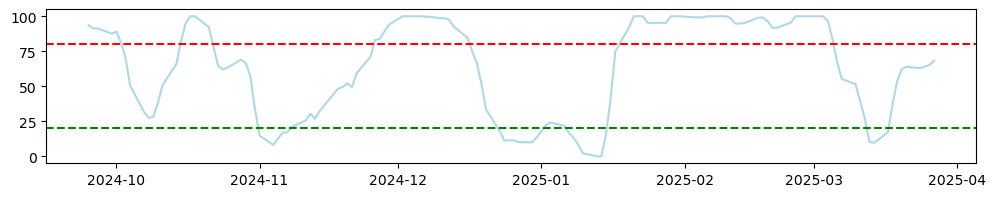

In [26]:

for symb in df_plot.index:
    print(symb,code2name_dict.get(symb,''))
    print_fund_change(symb)
    plot_stochastic_oscillator(symb, period=21, smooth_k=3, smooth_d=3)

In [27]:
df_filter = df_features.index.isin(normalize(df_features['STD']).index) & (df_features['STD']>0.005)

df_plot = df_features[df_filter].sort_values(by='Racio2',ascending=False).head(15)
df_plot

Growth       STD       Racio   D_Volat      Racio2  \
LU0300834669  1.896120  0.008739  213.535478  0.005850  182.593513   
LU0524465977  1.859475  0.008838  206.999565  0.006293  170.785579   
LU0572586591  1.139365  0.005692  194.911896  0.003911  164.190777   
GRE.PA        1.765631  0.010609  163.595157  0.005711  157.556424   
S7XE.DE       2.590338  0.012927  198.056945  0.009918  156.292265   
LNGA.L        9.998887  0.066759  149.326204  0.041287  133.512129   
UIMY.AS       0.679588  0.007547   86.075625  0.001257  129.142476   
LU0563745743  1.166858  0.006717  169.258441  0.005455  128.994698   
SC0U.DE       2.016340  0.011755  168.984787  0.009694  127.566571   
SC0Y.DE       1.010146  0.007884  124.323358  0.004574  115.097453   
YINN          7.020434  0.068925  101.421018  0.029829  108.729706   
EXSH.DE       0.904868  0.006653  131.495660  0.004857  106.899714   
EHDV.DE       0.809858  0.006977  111.775112  0.004689   95.360792   
XRH0.L        4.022633  0.035372  112.874882  0.029205   85.147683   
STZ.PA        0.961580  0.008407  110.809073  0.007124   82.239594   

              PricePosition  Oversold Exit  Overbought Entry    Amount EUR  
LU0300834669       1.000000          False             False           NaN  
LU0524465977       0.995044          False             False  27077.316548  
LU0572586591       1.000000          False             False           NaN  
GRE.PA             1.000000          False             False           NaN  
S7XE.DE            0.967168          False             False           NaN  
LNGA.L             0.122303          False             False           NaN  
UIMY.AS            0.952924          False             False           NaN  
LU0563745743       1.000000          False             False           NaN  
SC0U.DE            0.969676          False             False  20736.799316  
SC0Y.DE            0.997410          False             False           NaN  
YINN               0.672582          False             False  14038.011065  
EXSH.DE            0.956040          False             False           NaN  
EHDV.DE            0.957774          False             False           NaN  
XRH0.L             0.451980          False             False           NaN  
STZ.PA             0.975770          False             False           NaN

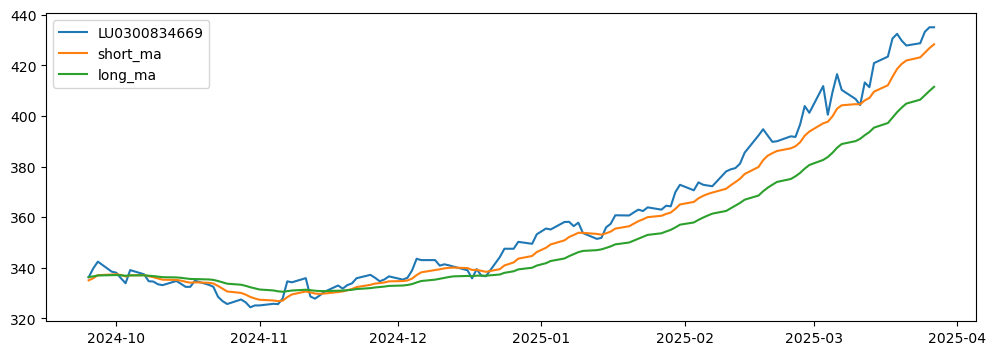

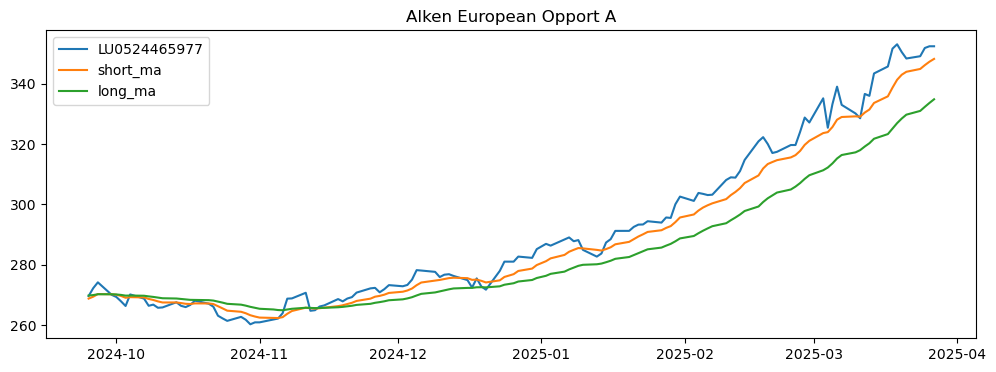

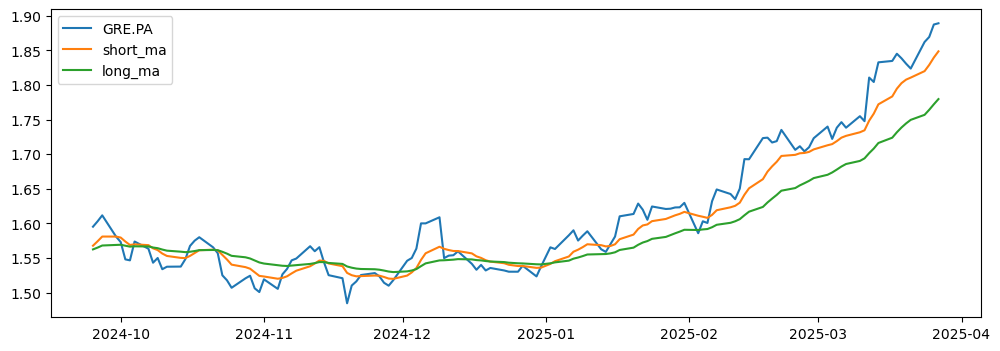

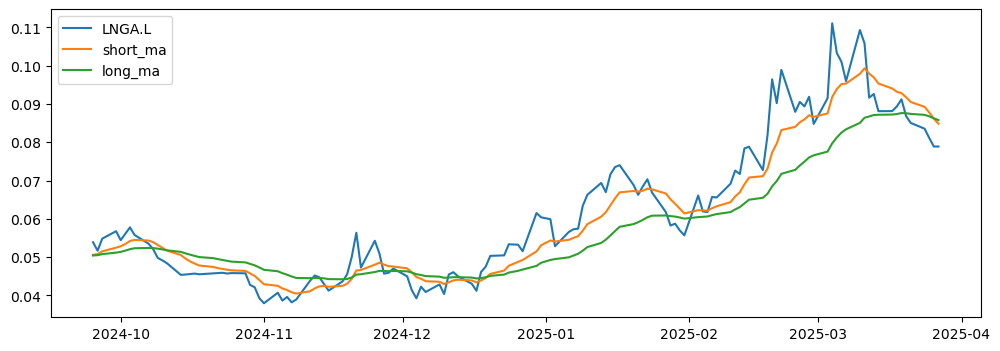

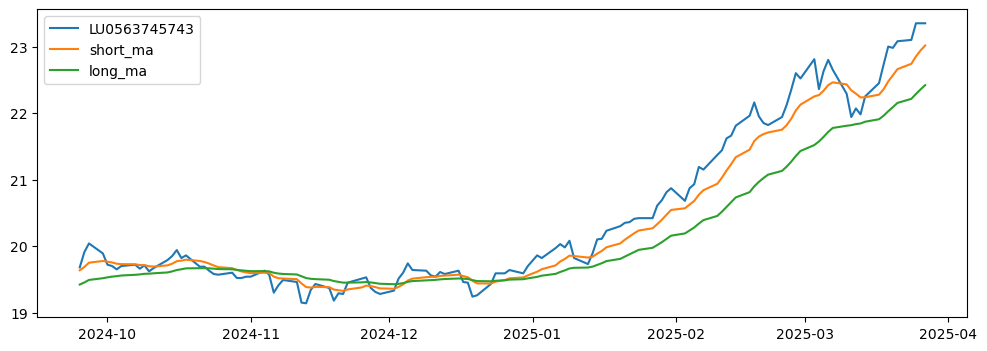

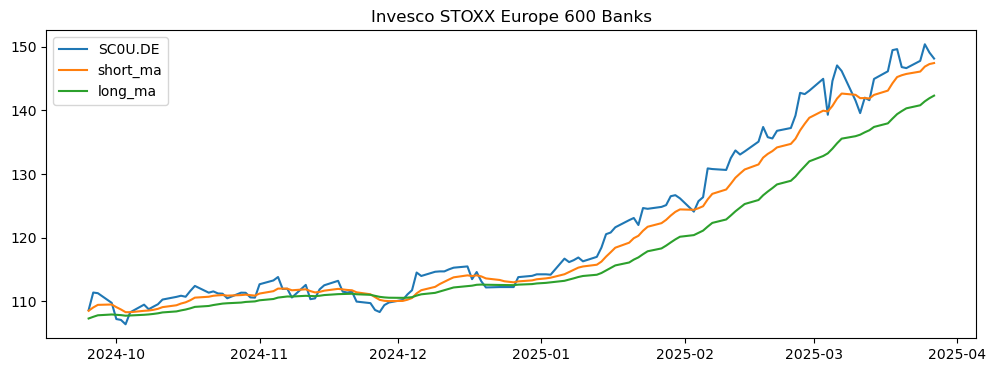

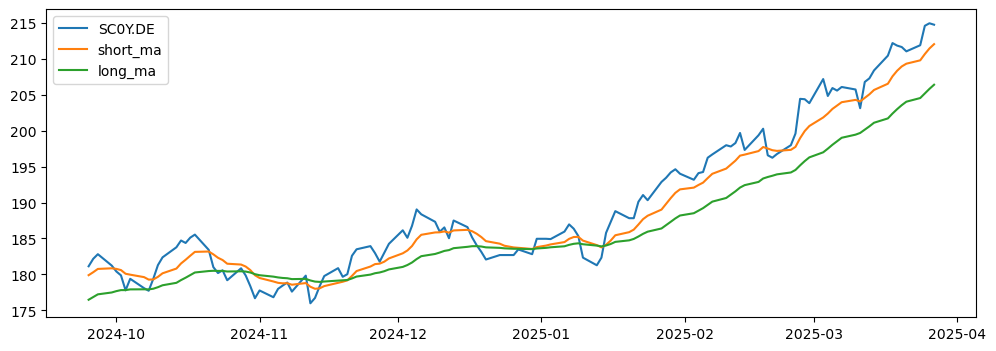

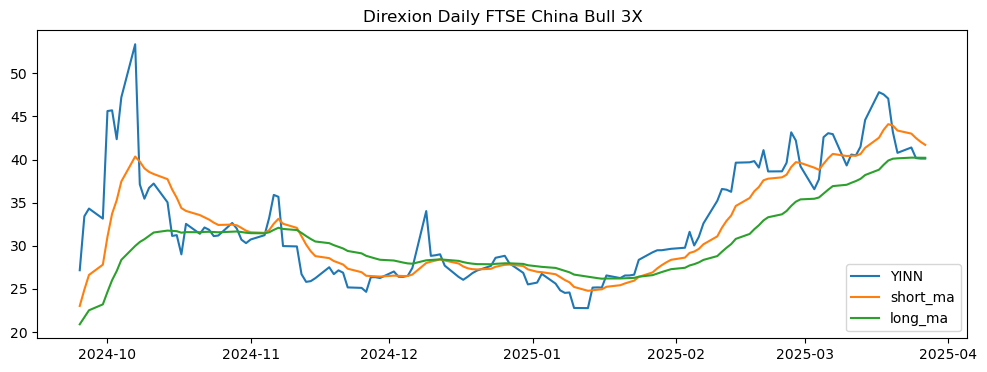

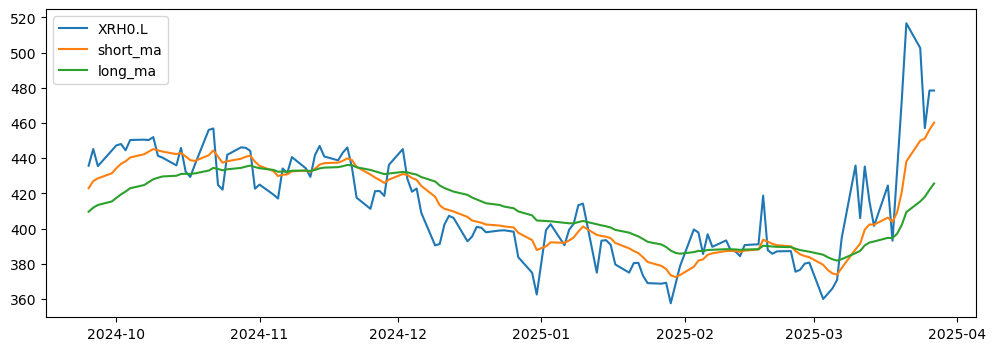

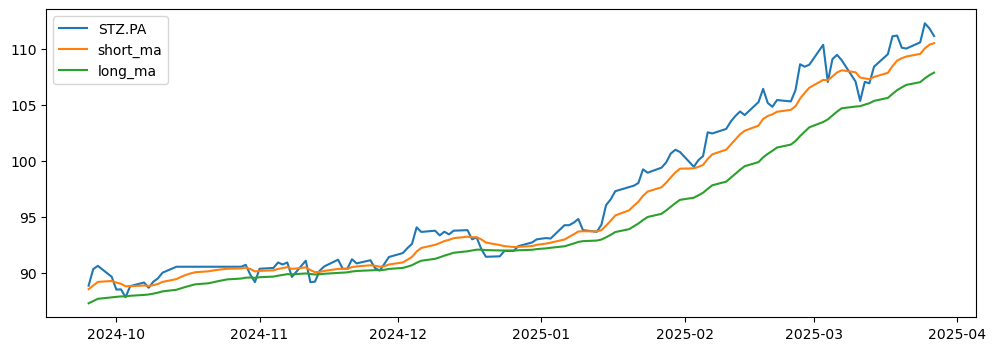

In [28]:

for symb in df_plot.index:
    print_fund_change(symb)

In [36]:
df_filter = df_features.index.isin(['LU1508158513'])
df_plot = df_features[df_filter].sort_values(by='Racio2',ascending=False).head(15)
df_plot


Growth       STD      Racio   D_Volat     Racio2  \
LU1508158513  0.203495  0.002543  68.215616  0.000884  80.498905   

              PricePosition  Oversold Exit  Overbought Entry  Amount EUR  
LU1508158513            1.0          False             False         NaN

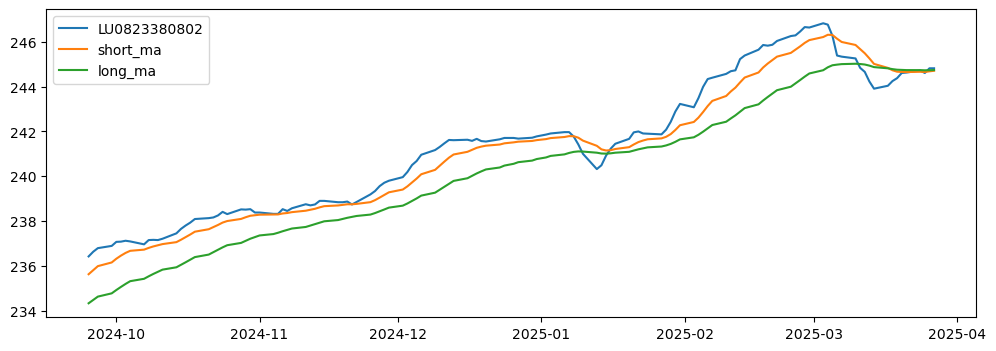

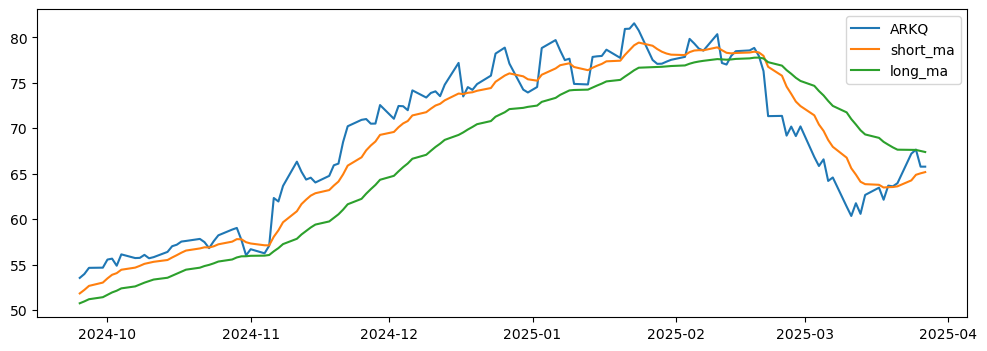

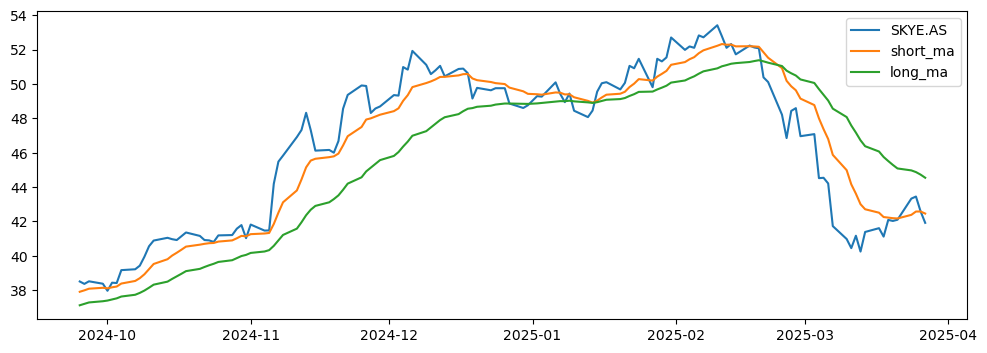

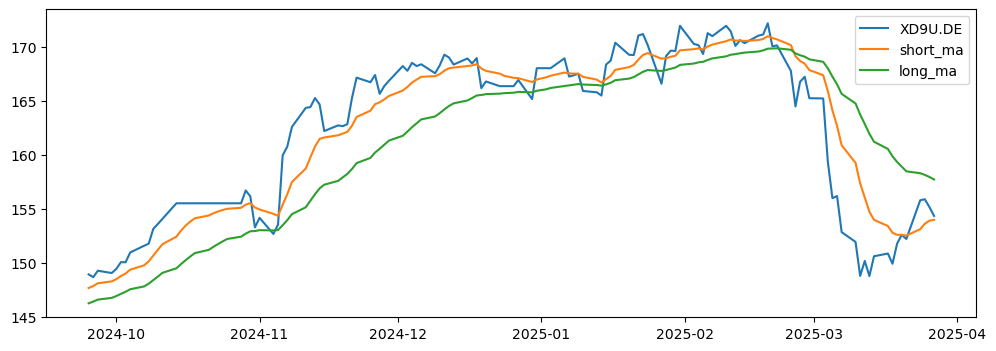

In [30]:
for symb in df_plot.index:
    print_fund_change(symb)

In [31]:
def calculate_correlations(single_series, df_timeseries):
    aligned_series, aligned_df = single_series.align(df_timeseries, join='inner', axis=0)
    
    # Step 2: Convert the aligned Series and DataFrame to NumPy arrays
    series_array = aligned_series.values  # 1D array (single time series)
    df_array = aligned_df.values  # 2D array (list of time series)
    
    # Step 3: Concatenate the single series as the first column with the DataFrame's time series
    combined_data = np.vstack([series_array, df_array.T])  # (n_time_series+1, n_dates) matrix
    
    # Step 4: Compute the correlation matrix using np.corrcoef (works on rows as variables)
    correlation_matrix = np.corrcoef(combined_data)
    
    # Step 5: Extract the correlations between the single series and each time series in the DataFrame
    # The correlation of the first row (single_series) with the remaining rows (df_timeseries)
    single_series_correlations = correlation_matrix[0, 1:]  # First row, excluding self-correlation
    
    # Step 6: Return the result as a Pandas Series with time series column names from df_timeseries
    result = pd.Series(single_series_correlations, index=aligned_df.columns, name='correlation')
    
    return result

def get_correlations():
    #find_top_correlated_pairs(df_quotes)
    corr_list = []

    # Ignore warnings only in this block
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for symb in relevant_etfs:
            df_tmp = pd.concat([df_quotes[symb].shift(1),df_quotes.drop(columns=[symb])],axis=1).apply(lambda x: x/x.shift(-1)).dropna()
            df_corr_tmp = calculate_correlations(df_tmp[symb], df_tmp.drop(columns=[symb])).dropna().reset_index().rename(columns={'index':'ts2'})
            df_corr_tmp = df_corr_tmp[df_corr_tmp['correlation'].apply(lambda x: abs(x)) >= 0.5]
            df_corr_tmp['ts1'] = symb
            corr_list.append(df_corr_tmp[['ts1','ts2','correlation']])

    return pd.concat(corr_list)


In [32]:
def get_negative_correlation():
    #df_corr = df_quotes.corr().reset_index().melt(id_vars='index', var_name='ts2', value_name='correlation').rename(columns={'index': 'ts1'})
    correlation_matrix = np.corrcoef(df_quotes.values, rowvar=False)
    df_corr = pd.DataFrame(correlation_matrix, index=df_quotes.columns, columns=df_quotes.columns).reset_index().melt(id_vars='index', var_name='ts2', value_name='correlation')
    df_corr = df_corr.rename(columns={'index': 'ts1'})
    grow = df_quotes.apply(lambda x: x.iloc[0]/x.loc[get_quote_date(days_ago=365//2)]-1)
    grow = grow[grow>0.015]
    filt = (df_corr['ts1']<df_corr['ts2']) & (df_corr['correlation']<-0.2) & df_corr['ts1'].isin(grow.index) & df_corr['ts2'].isin(grow.index)
    return df_corr[filt].dropna()

df_corr = get_negative_correlation().sort_values(by='correlation')
df_corr

ts1           ts2  correlation
10611764  LU0941349275           PSQ    -0.970454
10611751  IE00BFRSV973           PSQ    -0.967378
10609974  IE00B52VP557           PSQ    -0.967260
10611401  LU1046235815           PSQ    -0.964981
10609815  LU0336084032           PSQ    -0.964053
...                ...           ...          ...
9555370        DXS7.DE  LU0173614495    -0.200107
1511911            DOG  LU0080735201    -0.200102
7476152           IPOS  LU0736558973    -0.200074
9598963           IDRV  IE00BDRKSX26    -0.200065
10874568  LU0546919712           PXE    -0.200023

[29972 rows x 3 columns]

OrderedDict([('LU0119176310', 0.8886446190148066), ('PSQ', 0.1113553809851933)])


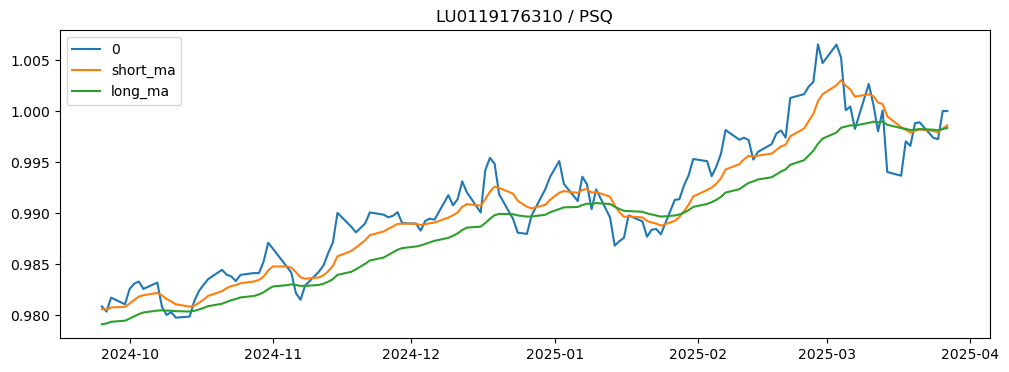

In [33]:
i=27 #17
df_tmp = df_quotes.loc[:get_quote_date(days_ago=365//2)].sort_index()[[df_corr.iloc[i]['ts1'],df_corr.iloc[i]['ts2']]]

mu = mean_historical_return(df_tmp)
S = CovarianceShrinkage(df_tmp).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
print(weights)
ds_tmp  = weights[df_corr.iloc[i]['ts1']]*df_quotes[df_corr.iloc[i]['ts1']]/df_quotes[df_corr.iloc[i]['ts1']].iloc[0] + weights[df_corr.iloc[i]['ts2']]*df_quotes[df_corr.iloc[i]['ts2']]/df_quotes[df_corr.iloc[i]['ts2']].iloc[0]

_, sma, lma,_,_ = change_trend(ds_tmp)
df_tmp = pd.concat([ds_tmp,sma,lma],axis=1)
title = code2name_dict.get(df_corr.iloc[i]['ts1'],df_corr.iloc[i]['ts1']) + " / " + code2name_dict.get(df_corr.iloc[i]['ts2'],df_corr.iloc[i]['ts2'])
df_tmp.iloc[:130].plot(title=title,figsize=(12,4))
plt.show()

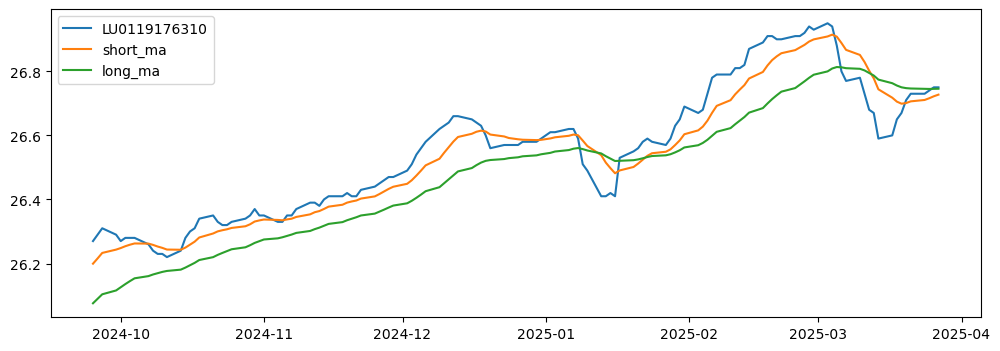

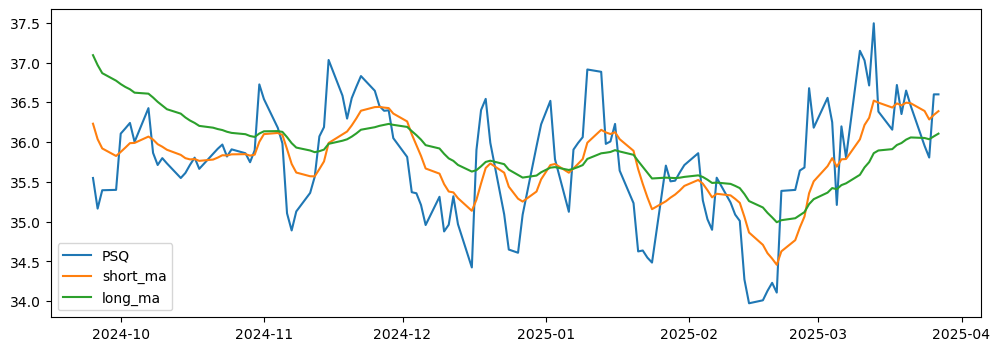

In [34]:
print_fund_change(df_corr.iloc[i]['ts1'])
print_fund_change(df_corr.iloc[i]['ts2'])

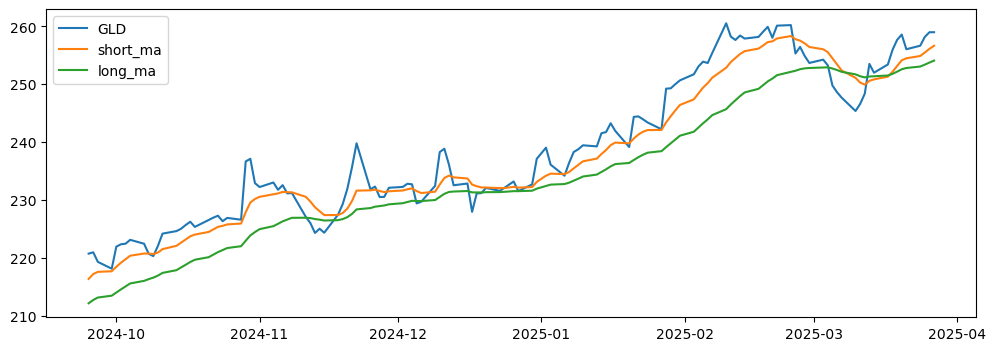

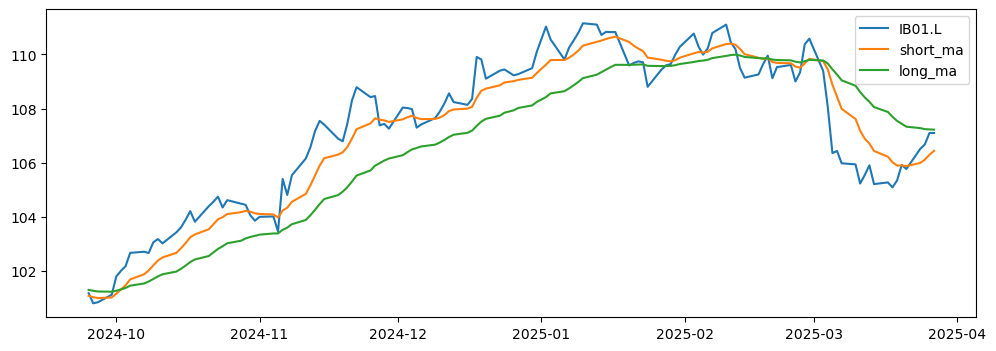

In [35]:
print_fund_change('GLD')
print_fund_change('IB01.L')